In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time
import random
from datetime import datetime
import cv2

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
from model import ResNet18Velocity
from train import train
from validate import validate
from test import test, test_models
from result import parameters_table, generate_log
from custom_transforms import Cutout, Shadowcasting

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# Load pre-computed mean and std
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {"rbg": {"mean": mean[:3],
                                "std": std[:3]},
                        "depth": {"mean": mean[3],
                                  "std": std[3]},
                        "normal": {"mean": mean[4:],
                                   "std": std[4:]}}

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4710, 0.5030, 0.4580]), 'std': tensor([0.1965, 0.1859, 0.1955])}, 'depth': {'mean': tensor([0.0855]), 'std': tensor([0.0684])}, 'normal': {'mean': tensor([0.4981, 0.5832, 0.8387]), 'std': tensor([0.1720, 0.1991, 0.1468])}}


In [4]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    
    # Perform horizontal flip of the image with a probability of 0.5
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(**params.learning.JITTER_PARAMS),

    # Randomly adds a black patch to the image
    #Cutout(0.5),
    
    # Randomly cast a shadow on the image
    #Shadowcasting(0.5),

    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

transform_depth = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["depth"]["mean"],
            std=NORMALIZE_PARAMS["depth"]["std"]
        ),
])

transform_normal = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["normal"]["mean"],
            std=NORMALIZE_PARAMS["normal"]["std"]
        ),
])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=train_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_test.csv",
    images_directory=params.learning.DATASET+"images_test",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE/(1-params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

69.0 % of the data for training (145 samples)
15.0 % of the data for validation (32 samples)
15.0 % of the data for testing (32 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model
model = ResNet18Velocity(**params.learning.NET_PARAMS).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(32,
                     params.learning.NET_PARAMS["nb_input_channels"],
                     params.learning.IMAGE_SHAPE[0],
                     params.learning.IMAGE_SHAPE[1]).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32, 10])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity(
  (resnet18): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [11]:
# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion_classification = nn.CrossEntropyLoss()

# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Load the bins midpoints
bins_midpoints = np.load(params.learning.DATASET+"bins_midpoints.npy")
bins_midpoints = torch.tensor(bins_midpoints[:, None],
                              dtype=torch.float32,
                              device=device)

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
# optimizer = optim.SGD([
#     {"params": base_params},
#     {"params": model.resnet18.fc.parameters(),
#      "lr": LEARNING_PARAMS["learning_rate"]*10},
# ],
#     lr=LEARNING_PARAMS["learning_rate"],
#     momentum=LEARNING_PARAMS["momentum"],
#     weight_decay=LEARNING_PARAMS["weight_decay"])

optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer, total_iters=LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the loss and accuracy values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy, train_regression_loss = train(model,
                                                              device,
                                                              train_loader,
                                                              optimizer,
                                                              scheduler,
                                                              criterion_classification,
                                                              criterion_regression,
                                                              bins_midpoints,
                                                              epoch)
    
    # Validation
    val_loss, val_accuracy, val_regression_loss = validate(model,
                                                           device,
                                                           val_loader,
                                                           criterion_classification,
                                                           criterion_regression,
                                                           bins_midpoints,
                                                           epoch) 
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy
    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  13.10344827586207
Validation accuracy:  18.75
Train regression loss:  1.2633022308349608
Validation regression loss:  1.5469884872436523


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  16.551724137931036
Validation accuracy:  18.75
Train regression loss:  1.2870066165924072
Validation regression loss:  1.5296146869659424


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  11.03448275862069
Validation accuracy:  18.75
Train regression loss:  1.2152556896209716
Validation regression loss:  1.5247527360916138


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  12.413793103448276
Validation accuracy:  18.75
Train regression loss:  1.3184176206588745
Validation regression loss:  1.5150301456451416


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  13.10344827586207
Validation accuracy:  18.75
Train regression loss:  1.2225409746170044
Validation regression loss:  1.5022571086883545


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  15.172413793103448
Validation accuracy:  12.5
Train regression loss:  1.196965265274048
Validation regression loss:  1.4875563383102417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  15.172413793103448
Validation accuracy:  12.5
Train regression loss:  1.200126576423645
Validation regression loss:  1.4759914875030518


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  15.172413793103448
Validation accuracy:  12.5
Train regression loss:  1.1371534764766693
Validation regression loss:  1.4656095504760742


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  16.551724137931036
Validation accuracy:  12.5
Train regression loss:  1.1908776998519897
Validation regression loss:  1.4540388584136963


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  1.1883958339691163
Validation regression loss:  1.4404157400131226


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  16.551724137931036
Validation accuracy:  12.5
Train regression loss:  1.1505695104598999
Validation regression loss:  1.4314091205596924


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.0
Validation accuracy:  15.625
Train regression loss:  1.1783729314804077
Validation regression loss:  1.4203412532806396


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  17.93103448275862
Validation accuracy:  18.75
Train regression loss:  1.2186179757118225
Validation regression loss:  1.4085841178894043


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  18.620689655172413
Validation accuracy:  18.75
Train regression loss:  1.1373210310935975
Validation regression loss:  1.4001754522323608


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  21.875
Train regression loss:  1.1172898411750793
Validation regression loss:  1.3911316394805908


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.0
Validation accuracy:  18.75
Train regression loss:  1.1348949790000915
Validation regression loss:  1.3805103302001953


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  15.625
Train regression loss:  1.133227801322937
Validation regression loss:  1.3722212314605713


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  15.625
Train regression loss:  1.1125540733337402
Validation regression loss:  1.3608276844024658


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  19.310344827586206
Validation accuracy:  15.625
Train regression loss:  1.0527395844459533
Validation regression loss:  1.350195050239563


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  1.0629552721977233
Validation regression loss:  1.3394701480865479


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  17.93103448275862
Validation accuracy:  12.5
Train regression loss:  1.0691465139389038
Validation regression loss:  1.330005168914795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  1.0348675727844239
Validation regression loss:  1.3196481466293335


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  1.065522885322571
Validation regression loss:  1.3153489828109741


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.0
Validation accuracy:  12.5
Train regression loss:  1.056393527984619
Validation regression loss:  1.3079707622528076


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  1.010718297958374
Validation regression loss:  1.297694444656372


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  1.065152382850647
Validation regression loss:  1.2906664609909058


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  1.030903661251068
Validation regression loss:  1.2883678674697876


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9977442026138306
Validation regression loss:  1.2821149826049805


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  1.0271856427192687
Validation regression loss:  1.275214672088623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9886147975921631
Validation regression loss:  1.2686583995819092


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  1.008676564693451
Validation regression loss:  1.2587910890579224


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9847470402717591
Validation regression loss:  1.2549667358398438


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9993717312812805
Validation regression loss:  1.2455694675445557


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.9961119413375854
Validation regression loss:  1.2418087720870972


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.9690507888793946
Validation regression loss:  1.2375056743621826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9863836407661438
Validation regression loss:  1.231432318687439


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.9180455327033996
Validation regression loss:  1.2234561443328857


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.9538096070289612
Validation regression loss:  1.2206050157546997


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9584146618843079
Validation regression loss:  1.2130000591278076


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.0
Validation accuracy:  12.5
Train regression loss:  0.9918846368789673
Validation regression loss:  1.2100422382354736


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9155977487564086
Validation regression loss:  1.2062273025512695


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9375846028327942
Validation regression loss:  1.1999261379241943


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.929305124282837
Validation regression loss:  1.1930744647979736


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9338886618614197
Validation regression loss:  1.1867501735687256


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9323060035705566
Validation regression loss:  1.1831181049346924


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8931345701217651
Validation regression loss:  1.1795885562896729


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.926368522644043
Validation regression loss:  1.1794190406799316


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9594007015228272
Validation regression loss:  1.1735918521881104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9033781051635742
Validation regression loss:  1.1687978506088257


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.868376761674881
Validation regression loss:  1.1655731201171875


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8957617282867432
Validation regression loss:  1.161327838897705


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9363413691520691
Validation regression loss:  1.1544702053070068


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9297082304954529
Validation regression loss:  1.14997136592865


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8916882991790771
Validation regression loss:  1.1459406614303589


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8958696007728577
Validation regression loss:  1.1425766944885254


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8743873715400696
Validation regression loss:  1.1383769512176514


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.903080677986145
Validation regression loss:  1.138023853302002


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8535491466522217
Validation regression loss:  1.1366498470306396


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8892989039421082
Validation regression loss:  1.1322145462036133


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8891257166862487
Validation regression loss:  1.125147819519043


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8345440804958344
Validation regression loss:  1.1256626844406128


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9027019262313842
Validation regression loss:  1.121985673904419


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8634249329566955
Validation regression loss:  1.1191970109939575


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8772194027900696
Validation regression loss:  1.1166150569915771


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8695331573486328
Validation regression loss:  1.1140189170837402


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8580655872821807
Validation regression loss:  1.1105554103851318


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8510789752006531
Validation regression loss:  1.111796259880066


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.0
Validation accuracy:  12.5
Train regression loss:  0.8406678795814514
Validation regression loss:  1.107176423072815


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.9029885053634643
Validation regression loss:  1.1013482809066772


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8244421243667602
Validation regression loss:  1.0999305248260498


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8848884582519532
Validation regression loss:  1.0970749855041504


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8797094464302063
Validation regression loss:  1.094910979270935


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8035724759101868
Validation regression loss:  1.089390754699707


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8504143834114075
Validation regression loss:  1.0893025398254395


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8367012798786163
Validation regression loss:  1.0891649723052979


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8490742802619934
Validation regression loss:  1.0893890857696533


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8737792134284973
Validation regression loss:  1.0899577140808105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8530160665512085
Validation regression loss:  1.0870234966278076


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8248058676719665
Validation regression loss:  1.0830861330032349


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8266369223594665
Validation regression loss:  1.0801433324813843


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8150383114814759
Validation regression loss:  1.078256368637085


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.835784912109375
Validation regression loss:  1.0752220153808594


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.819835650920868
Validation regression loss:  1.0728905200958252


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8188736438751221
Validation regression loss:  1.0715805292129517


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8078791618347168
Validation regression loss:  1.0678722858428955


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8232175827026367
Validation regression loss:  1.0652583837509155


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8141080617904664
Validation regression loss:  1.0628790855407715


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8264457941055298
Validation regression loss:  1.061069130897522


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.830520498752594
Validation regression loss:  1.0602898597717285


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.814090371131897
Validation regression loss:  1.05696702003479


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7898252606391907
Validation regression loss:  1.0554869174957275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7742278397083282
Validation regression loss:  1.055382251739502


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8049543380737305
Validation regression loss:  1.0521875619888306


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8026710748672485
Validation regression loss:  1.0525915622711182


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8469773888587951
Validation regression loss:  1.0501277446746826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8226560473442077
Validation regression loss:  1.0482292175292969


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8358539581298828
Validation regression loss:  1.0462915897369385


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8170226573944092
Validation regression loss:  1.049281358718872


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8054777264595032
Validation regression loss:  1.0460753440856934


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.796688687801361
Validation regression loss:  1.045306921005249


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8018871426582337
Validation regression loss:  1.0436121225357056


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7844311594963074
Validation regression loss:  1.0418977737426758


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8247081875801087
Validation regression loss:  1.038667917251587


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8037324905395508
Validation regression loss:  1.0385289192199707


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7800956964492798
Validation regression loss:  1.0363476276397705


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7814408540725708
Validation regression loss:  1.0355144739151


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.8289745688438416
Validation regression loss:  1.0336281061172485


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7834610342979431
Validation regression loss:  1.0334441661834717


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8211919903755188
Validation regression loss:  1.035749912261963


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8062706828117371
Validation regression loss:  1.0335693359375


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.8087154150009155
Validation regression loss:  1.0305190086364746


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7946807146072388
Validation regression loss:  1.0291200876235962


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7886261105537414
Validation regression loss:  1.0274884700775146


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8038385152816773
Validation regression loss:  1.026401400566101


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8091503262519837
Validation regression loss:  1.0248079299926758


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.0
Validation accuracy:  12.5
Train regression loss:  0.8183722138404846
Validation regression loss:  1.0227763652801514


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.7810720920562744
Validation regression loss:  1.0232961177825928


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.811651885509491
Validation regression loss:  1.0211886167526245


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.7796333193778991
Validation regression loss:  1.0221954584121704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.768658173084259
Validation regression loss:  1.0209814310073853


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8041606307029724
Validation regression loss:  1.0206609964370728


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7649020314216614
Validation regression loss:  1.0183358192443848


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7770980715751648
Validation regression loss:  1.0160250663757324


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7604959607124329
Validation regression loss:  1.017638921737671


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.7627707481384277
Validation regression loss:  1.016133189201355


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.7867413520812988
Validation regression loss:  1.0139493942260742


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.0
Validation accuracy:  12.5
Train regression loss:  0.8051963090896607
Validation regression loss:  1.0122770071029663


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.7752970337867737
Validation regression loss:  1.0123425722122192


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7880656480789184
Validation regression loss:  1.0124168395996094


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7867100954055786
Validation regression loss:  1.0092694759368896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.7881944417953491
Validation regression loss:  1.0089651346206665


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8051188230514527
Validation regression loss:  1.007195234298706


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.773258101940155
Validation regression loss:  1.0076963901519775


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.747637414932251
Validation regression loss:  1.0070717334747314


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7834936499595642
Validation regression loss:  1.004084825515747


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7961971163749695
Validation regression loss:  1.0023139715194702


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7433892130851746
Validation regression loss:  1.0028417110443115


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7360599935054779
Validation regression loss:  1.001022219657898


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7559480190277099
Validation regression loss:  0.9999039173126221


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.7632341027259827
Validation regression loss:  1.0010807514190674


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7908976793289184
Validation regression loss:  0.9978369474411011


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7380754292011261
Validation regression loss:  0.9983420372009277


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7491230010986328
Validation regression loss:  0.9994261264801025


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  20.689655172413794
Validation accuracy:  12.5
Train regression loss:  0.8106861352920532
Validation regression loss:  0.9966687560081482


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7649595379829407
Validation regression loss:  0.995732843875885


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.8074136972427368
Validation regression loss:  0.9959011077880859


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7600452065467834
Validation regression loss:  0.9943376779556274


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.7534448504447937
Validation regression loss:  0.9953639507293701


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.773337435722351
Validation regression loss:  0.9950834512710571


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7459045886993408
Validation regression loss:  0.99334716796875


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7356858432292939
Validation regression loss:  0.9919240474700928


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7534221768379211
Validation regression loss:  0.9920063018798828


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.7376917421817779
Validation regression loss:  0.9903661608695984


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7446990609169006
Validation regression loss:  0.9886151552200317


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7832891702651977
Validation regression loss:  0.9882794618606567


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7685850143432618
Validation regression loss:  0.9890267848968506


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7231990933418274
Validation regression loss:  0.9871301651000977


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7709990859031677
Validation regression loss:  0.9879093170166016


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.74362433552742
Validation regression loss:  0.9861099720001221


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7700646162033081
Validation regression loss:  0.9869914650917053


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7558420896530151
Validation regression loss:  0.9887374043464661


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7503773808479309
Validation regression loss:  0.987082839012146


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.74768625497818
Validation regression loss:  0.9853538870811462


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7410254597663879
Validation regression loss:  0.9847737550735474


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7297163724899292
Validation regression loss:  0.9835994243621826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7193486392498016
Validation regression loss:  0.9850331544876099


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7377077460289001
Validation regression loss:  0.9832220077514648


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7455240845680237
Validation regression loss:  0.9825035333633423


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7530046820640564
Validation regression loss:  0.9811293482780457


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7580524921417237
Validation regression loss:  0.9814127087593079


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  21.379310344827587
Validation accuracy:  12.5
Train regression loss:  0.7631225705146789
Validation regression loss:  0.981049656867981


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7444740056991577
Validation regression loss:  0.980057418346405


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7823123812675477
Validation regression loss:  0.9806619882583618


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7826582551002502
Validation regression loss:  0.9797587990760803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7558325290679931
Validation regression loss:  0.9790021777153015


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7264844477176666
Validation regression loss:  0.9788964986801147


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7407117486000061
Validation regression loss:  0.9770849943161011


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7903517961502076
Validation regression loss:  0.9767684936523438


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7381087303161621
Validation regression loss:  0.9753531813621521


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7347438097000122
Validation regression loss:  0.9758675694465637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7404675960540772
Validation regression loss:  0.976223349571228


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7335859894752502
Validation regression loss:  0.9752300977706909


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7713281273841858
Validation regression loss:  0.9778900146484375


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7422313928604126
Validation regression loss:  0.975100040435791


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7655079364776611
Validation regression loss:  0.9741532802581787


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.8174048662185669
Validation regression loss:  0.974146842956543


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7628208279609681
Validation regression loss:  0.9736515283584595


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7836971282958984
Validation regression loss:  0.9698330760002136


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7442144513130188
Validation regression loss:  0.9696575403213501


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7557648301124573
Validation regression loss:  0.9692521095275879


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7547727584838867
Validation regression loss:  0.9694209098815918


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7848364472389221
Validation regression loss:  0.9688429236412048


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7302041411399841
Validation regression loss:  0.9663844704627991


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7902769684791565
Validation regression loss:  0.9660683870315552


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.762197756767273
Validation regression loss:  0.9663403630256653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.06896551724138
Validation accuracy:  12.5
Train regression loss:  0.7330994367599487
Validation regression loss:  0.9647054672241211


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7287793159484863
Validation regression loss:  0.9650285243988037


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7177566409111023
Validation regression loss:  0.9638472199440002


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7696448564529419
Validation regression loss:  0.9656027555465698


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7606837749481201
Validation regression loss:  0.9661086201667786


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7486295640468598
Validation regression loss:  0.9628520011901855


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7578002214431763
Validation regression loss:  0.9616521596908569


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7344785928726196
Validation regression loss:  0.9602811336517334


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7841461181640625
Validation regression loss:  0.9595154523849487


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7285895228385926
Validation regression loss:  0.96001136302948


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7442644715309144
Validation regression loss:  0.9599752426147461


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7300803899765015
Validation regression loss:  0.959862232208252


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.7518886923789978
Validation regression loss:  0.9598895311355591


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7619307160377502
Validation regression loss:  0.9595288038253784


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7244177758693695
Validation regression loss:  0.9602292776107788


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7635153293609619
Validation regression loss:  0.9585052728652954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7641792058944702
Validation regression loss:  0.9587831497192383


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7860358357429504
Validation regression loss:  0.9580304026603699


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7302617430686951
Validation regression loss:  0.9563976526260376


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7681459903717041
Validation regression loss:  0.9566617012023926


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7171481549739838
Validation regression loss:  0.95374596118927


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7447262406349182
Validation regression loss:  0.9543823003768921


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7355693697929382
Validation regression loss:  0.9549326300621033


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7352870821952819
Validation regression loss:  0.9552916884422302


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7609672546386719
Validation regression loss:  0.9540084004402161


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7536311388015747
Validation regression loss:  0.9532312154769897


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7540035605430603
Validation regression loss:  0.9532865285873413


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7525165796279907
Validation regression loss:  0.9517319202423096


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7056478500366211
Validation regression loss:  0.9516614079475403


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.768363070487976
Validation regression loss:  0.9532886147499084


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.751940381526947
Validation regression loss:  0.9517823457717896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.75307137966156
Validation regression loss:  0.950586199760437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7176758885383606
Validation regression loss:  0.949495255947113


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7387937903404236
Validation regression loss:  0.9489355087280273


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7297028660774231
Validation regression loss:  0.9492450952529907


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7443750739097595
Validation regression loss:  0.9495659470558167


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7012452244758606
Validation regression loss:  0.9491831660270691


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7464315056800842
Validation regression loss:  0.9490089416503906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7730834364891053
Validation regression loss:  0.9490712881088257


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7481571078300476
Validation regression loss:  0.948053240776062


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.739245879650116
Validation regression loss:  0.9475343823432922


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7182408571243286
Validation regression loss:  0.9468183517456055


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7499731183052063
Validation regression loss:  0.9463382959365845


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7131811738014221
Validation regression loss:  0.9458132982254028


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7139976441860199
Validation regression loss:  0.9463578462600708


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7318942308425903
Validation regression loss:  0.946628987789154


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7402653336524964
Validation regression loss:  0.9457526206970215


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7240904450416565
Validation regression loss:  0.945117175579071


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7430810689926147
Validation regression loss:  0.9446622133255005


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7250406384468079
Validation regression loss:  0.9435017108917236


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7466715812683106
Validation regression loss:  0.9434043765068054


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7610736966133118
Validation regression loss:  0.942729115486145


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7557687401771546
Validation regression loss:  0.9421862363815308


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7416522383689881
Validation regression loss:  0.94122314453125


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7691697716712952
Validation regression loss:  0.9410145282745361


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7205572903156281
Validation regression loss:  0.9410499930381775


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7246494174003602
Validation regression loss:  0.9406732320785522


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7085513055324555
Validation regression loss:  0.9401370286941528


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7180015802383423
Validation regression loss:  0.9401729106903076


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7484087705612182
Validation regression loss:  0.9384672045707703


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7218626737594604
Validation regression loss:  0.9384267926216125


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7731626272201538
Validation regression loss:  0.9379256963729858


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7780882239341735
Validation regression loss:  0.9374569654464722


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.755258321762085
Validation regression loss:  0.9358258247375488


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7536429405212403
Validation regression loss:  0.9369950890541077


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7326880931854248
Validation regression loss:  0.9362197518348694


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7484619557857514
Validation regression loss:  0.9356949925422668


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7301233887672425
Validation regression loss:  0.935279369354248


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7167270898818969
Validation regression loss:  0.9347221851348877


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7406840682029724
Validation regression loss:  0.934583842754364


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7372483015060425
Validation regression loss:  0.9346113204956055


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7263193011283875
Validation regression loss:  0.9325299263000488


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7282132863998413
Validation regression loss:  0.9313476085662842


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7391626834869385
Validation regression loss:  0.931702196598053


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7263748049736023
Validation regression loss:  0.9323737621307373


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7853322386741638
Validation regression loss:  0.9331948757171631


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  12.5
Train regression loss:  0.7389934420585632
Validation regression loss:  0.9316771030426025


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7370479941368103
Validation regression loss:  0.9323185086250305


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7144259691238404
Validation regression loss:  0.9330964088439941


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7700017094612122
Validation regression loss:  0.9325642585754395


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.710751610994339
Validation regression loss:  0.9324089288711548


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7098731338977814
Validation regression loss:  0.9320716261863708


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.701065182685852
Validation regression loss:  0.9320352077484131


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.736203384399414
Validation regression loss:  0.9312346577644348


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.746374249458313
Validation regression loss:  0.9291750192642212


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7215263605117798
Validation regression loss:  0.927333652973175


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7228778600692749
Validation regression loss:  0.9289587140083313


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7471725821495057
Validation regression loss:  0.9284682273864746


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7309720158576966
Validation regression loss:  0.9292766451835632


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7259716510772705
Validation regression loss:  0.9286856651306152


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  12.5
Train regression loss:  0.7137197136878968
Validation regression loss:  0.9272765517234802


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.6955527842044831
Validation regression loss:  0.92659592628479


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.6955962479114532
Validation regression loss:  0.9259258508682251


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  23.448275862068964
Validation accuracy:  12.5
Train regression loss:  0.7499788284301758
Validation regression loss:  0.9264475107192993


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7407042264938355
Validation regression loss:  0.9259099960327148


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7279232800006866
Validation regression loss:  0.9258605241775513


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7249445199966431
Validation regression loss:  0.9247661232948303


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  12.5
Train regression loss:  0.7361518383026123
Validation regression loss:  0.9248018264770508


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7672121047973632
Validation regression loss:  0.9235179424285889


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  12.5
Train regression loss:  0.7267686247825622
Validation regression loss:  0.9224045276641846


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  12.5
Train regression loss:  0.7183699250221253
Validation regression loss:  0.922196626663208


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.6986338019371032
Validation regression loss:  0.9214332103729248


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7173847019672394
Validation regression loss:  0.9207298159599304


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7376416683197021
Validation regression loss:  0.9194959402084351


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7628841876983643
Validation regression loss:  0.919349193572998


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.6951746642589569
Validation regression loss:  0.9190106987953186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7475947141647339
Validation regression loss:  0.9193388819694519


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.74669930934906
Validation regression loss:  0.919045090675354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  15.625
Train regression loss:  0.719874382019043
Validation regression loss:  0.9193577766418457


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7214282989501953
Validation regression loss:  0.9191471338272095


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  15.625
Train regression loss:  0.7345033645629883
Validation regression loss:  0.9175987243652344


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7340609788894653
Validation regression loss:  0.9162625074386597


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7244431853294373
Validation regression loss:  0.9153748750686646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7361233830451965
Validation regression loss:  0.9156147241592407


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  15.625
Train regression loss:  0.7165143847465515
Validation regression loss:  0.9150218367576599


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  15.625
Train regression loss:  0.751905357837677
Validation regression loss:  0.9148803949356079


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7166679620742797
Validation regression loss:  0.9152239561080933


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.137931034482758
Validation accuracy:  15.625
Train regression loss:  0.7336087346076965
Validation regression loss:  0.9142133593559265


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.6810341954231263
Validation regression loss:  0.913054883480072


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.7159641504287719
Validation regression loss:  0.9137347340583801


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  15.625
Train regression loss:  0.7516616225242615
Validation regression loss:  0.9129830598831177


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7068440675735473
Validation regression loss:  0.9124902486801147


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.6975468039512634
Validation regression loss:  0.913194477558136


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  22.75862068965517
Validation accuracy:  12.5
Train regression loss:  0.6992677390575409
Validation regression loss:  0.9137293696403503


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7256227135658264
Validation regression loss:  0.9126523733139038


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.70607990026474
Validation regression loss:  0.912825345993042


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7149731278419494
Validation regression loss:  0.9130210876464844


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7177729129791259
Validation regression loss:  0.9129043221473694


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7437228322029114
Validation regression loss:  0.9132474660873413


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7177269935607911
Validation regression loss:  0.9128249883651733


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7237649083137512
Validation regression loss:  0.9125630855560303


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  12.5
Train regression loss:  0.7182509660720825
Validation regression loss:  0.911860466003418


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7434778094291687
Validation regression loss:  0.9108712673187256


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7378604412078857
Validation regression loss:  0.9110116362571716


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7420297265052795
Validation regression loss:  0.9103522300720215


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7331338882446289
Validation regression loss:  0.9095486402511597


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7700438141822815
Validation regression loss:  0.9093027710914612


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7217425346374512
Validation regression loss:  0.9085330367088318


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7230739116668701
Validation regression loss:  0.9076030254364014


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.727673065662384
Validation regression loss:  0.9071178436279297


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  12.5
Train regression loss:  0.725871479511261
Validation regression loss:  0.9057376980781555


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7093770384788514
Validation regression loss:  0.906988263130188


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.757096266746521
Validation regression loss:  0.905011773109436


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  12.5
Train regression loss:  0.7125660181045532
Validation regression loss:  0.9044826030731201


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  15.625
Train regression loss:  0.7583569884300232
Validation regression loss:  0.9032973647117615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  12.5
Train regression loss:  0.7401737689971923
Validation regression loss:  0.9025589227676392


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7106032133102417
Validation regression loss:  0.9017714262008667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.7236928343772888
Validation regression loss:  0.9027673006057739


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7528813660144806
Validation regression loss:  0.9028183221817017


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7159974217414856
Validation regression loss:  0.9024344086647034


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  12.5
Train regression loss:  0.7442528367042541
Validation regression loss:  0.9032642245292664


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  12.5
Train regression loss:  0.7143804669380188
Validation regression loss:  0.902878999710083


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  12.5
Train regression loss:  0.7475199222564697
Validation regression loss:  0.9020940661430359


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.7176857233047486
Validation regression loss:  0.9018006324768066


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.6851716041564941
Validation regression loss:  0.9017288684844971


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7394295573234558
Validation regression loss:  0.9015560150146484


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  15.625
Train regression loss:  0.7694527626037597
Validation regression loss:  0.899652361869812


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7166967988014221
Validation regression loss:  0.9001207947731018


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7108450412750245
Validation regression loss:  0.9001648426055908


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.7197836756706237
Validation regression loss:  0.8986892700195312


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  15.625
Train regression loss:  0.6856087982654572
Validation regression loss:  0.8972344398498535


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.7367695510387421
Validation regression loss:  0.8966941237449646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  12.5
Train regression loss:  0.6812298834323883
Validation regression loss:  0.8961648344993591


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.6985705375671387
Validation regression loss:  0.8968313932418823


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  15.625
Train regression loss:  0.7052953958511352
Validation regression loss:  0.8963841199874878


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7070509552955627
Validation regression loss:  0.8958007097244263


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  15.625
Train regression loss:  0.7079614281654358
Validation regression loss:  0.8948338627815247


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  25.517241379310345
Validation accuracy:  15.625
Train regression loss:  0.686036866903305
Validation regression loss:  0.8942800760269165


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  24.82758620689655
Validation accuracy:  12.5
Train regression loss:  0.7252553343772888
Validation regression loss:  0.8939998149871826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  15.625
Train regression loss:  0.7388759613037109
Validation regression loss:  0.8933900594711304


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.6957841277122497
Validation regression loss:  0.8935049772262573


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.7020169734954834
Validation regression loss:  0.8934266567230225


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7065878272056579
Validation regression loss:  0.892543613910675


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  15.625
Train regression loss:  0.7060074210166931
Validation regression loss:  0.8913016319274902


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.6991571068763733
Validation regression loss:  0.8892743587493896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  15.625
Train regression loss:  0.7309153914451599
Validation regression loss:  0.8900107741355896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.7200031638145447
Validation regression loss:  0.8909043669700623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.7174486994743348
Validation regression loss:  0.8893666863441467


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.725775146484375
Validation regression loss:  0.889320433139801


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.7286474585533143
Validation regression loss:  0.8866924047470093


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.6828254818916321
Validation regression loss:  0.8871452212333679


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7415317893028259
Validation regression loss:  0.8877257704734802


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  12.5
Train regression loss:  0.6758879780769348
Validation regression loss:  0.8869414925575256


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.7348817586898804
Validation regression loss:  0.886925995349884


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.6935996770858764
Validation regression loss:  0.8862859010696411


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.7085870981216431
Validation regression loss:  0.8850606679916382


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  15.625
Train regression loss:  0.7035651445388794
Validation regression loss:  0.8868346214294434


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  15.625
Train regression loss:  0.6942593693733216
Validation regression loss:  0.8865853548049927


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.7503313422203064
Validation regression loss:  0.8864292502403259


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.7147445201873779
Validation regression loss:  0.8865479230880737


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.6891645789146423
Validation regression loss:  0.8859618902206421


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  12.5
Train regression loss:  0.6740714251995087
Validation regression loss:  0.8864973187446594


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.7046711206436157
Validation regression loss:  0.8859832882881165


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.6921339869499207
Validation regression loss:  0.8857372999191284


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.702411150932312
Validation regression loss:  0.8843156099319458


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.6784443140029908
Validation regression loss:  0.8824902772903442


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  15.625
Train regression loss:  0.7266140222549439
Validation regression loss:  0.8831123113632202


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7150810837745667
Validation regression loss:  0.8832814693450928


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.682510107755661
Validation regression loss:  0.8844693899154663


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  15.625
Train regression loss:  0.6819296956062317
Validation regression loss:  0.8848553895950317


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  15.625
Train regression loss:  0.6974799394607544
Validation regression loss:  0.8836076259613037


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.7488847732543945
Validation regression loss:  0.8829580545425415


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.20689655172414
Validation accuracy:  15.625
Train regression loss:  0.7126970291137695
Validation regression loss:  0.8813725113868713


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.719337809085846
Validation regression loss:  0.8811450004577637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.7084756672382355
Validation regression loss:  0.8818645477294922


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.6914271593093873
Validation regression loss:  0.8815917372703552


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.719050943851471
Validation regression loss:  0.8815116882324219


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  15.625
Train regression loss:  0.6788391828536987
Validation regression loss:  0.8805700540542603


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.6866636633872986
Validation regression loss:  0.8797009587287903


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.7071720957756042
Validation regression loss:  0.8791639804840088


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.6734527766704559
Validation regression loss:  0.8780907392501831


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  15.625
Train regression loss:  0.6963657140731812
Validation regression loss:  0.8777848482131958


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.6747255146503448
Validation regression loss:  0.8772547245025635


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.7167305231094361
Validation regression loss:  0.8775713443756104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.7283100247383117
Validation regression loss:  0.877001166343689


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.7655717313289643
Validation regression loss:  0.8762787580490112


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.7211094379425049
Validation regression loss:  0.8753820657730103


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.6792815208435059
Validation regression loss:  0.8763986825942993


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.683756822347641
Validation regression loss:  0.8739297389984131


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.7034427404403687
Validation regression loss:  0.8727368712425232


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.7024015188217163
Validation regression loss:  0.8726152181625366


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  26.896551724137932
Validation accuracy:  15.625
Train regression loss:  0.738657021522522
Validation regression loss:  0.8727419376373291


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.7006855249404907
Validation regression loss:  0.8737906217575073


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.7055861353874207
Validation regression loss:  0.8748083114624023


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6944220423698425
Validation regression loss:  0.8731274604797363


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.7131811738014221
Validation regression loss:  0.8737565279006958


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.7088556528091431
Validation regression loss:  0.8746424913406372


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.7103603601455688
Validation regression loss:  0.8730137348175049


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  27.586206896551722
Validation accuracy:  15.625
Train regression loss:  0.7521941065788269
Validation regression loss:  0.872702956199646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.6968814253807067
Validation regression loss:  0.8730746507644653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.681198251247406
Validation regression loss:  0.8713245391845703


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.6901418566703796
Validation regression loss:  0.8706945180892944


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.6936119318008422
Validation regression loss:  0.8706392049789429


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.6953141689300537
Validation regression loss:  0.8687523603439331


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.742707085609436
Validation regression loss:  0.8680286407470703


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.6930618524551392
Validation regression loss:  0.866276741027832


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.7105256795883179
Validation regression loss:  0.8663919568061829


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  15.625
Train regression loss:  0.6937505006790161
Validation regression loss:  0.8662614822387695


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.7085890650749207
Validation regression loss:  0.8661725521087646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6842163920402526
Validation regression loss:  0.8658152222633362


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.702510392665863
Validation regression loss:  0.8643552660942078


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.10344827586207
Validation accuracy:  15.625
Train regression loss:  0.7104903817176819
Validation regression loss:  0.8640733957290649


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.7046903371810913
Validation regression loss:  0.8663622140884399


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.6774678289890289
Validation regression loss:  0.8650364875793457


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.7182623744010925
Validation regression loss:  0.8647773265838623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.7074086487293243
Validation regression loss:  0.8638304471969604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.7195453763008117
Validation regression loss:  0.863532304763794


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.6854695916175843
Validation regression loss:  0.8610774278640747


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.6840919256210327
Validation regression loss:  0.8603323698043823


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6720529198646545
Validation regression loss:  0.8603281378746033


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6836642861366272
Validation regression loss:  0.8615013360977173


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.6901365876197815
Validation regression loss:  0.8613237738609314


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  15.625
Train regression loss:  0.707612156867981
Validation regression loss:  0.8615038394927979


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.6993127822875976
Validation regression loss:  0.8593235015869141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.6992793679237366
Validation regression loss:  0.8583357930183411


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.692322289943695
Validation regression loss:  0.8588459491729736


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.68955979347229
Validation regression loss:  0.8581857681274414


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6900075018405915
Validation regression loss:  0.8585871458053589


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6781298041343689
Validation regression loss:  0.857282280921936


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.275862068965516
Validation accuracy:  15.625
Train regression loss:  0.6670471131801605
Validation regression loss:  0.8581556081771851


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6626428067684174
Validation regression loss:  0.8578492403030396


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.7194736957550049
Validation regression loss:  0.8579099178314209


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.6926375031471252
Validation regression loss:  0.8585140705108643


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  18.75
Train regression loss:  0.697445523738861
Validation regression loss:  0.8585059642791748


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.7043854236602783
Validation regression loss:  0.8578031659126282


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6697908282279968
Validation regression loss:  0.8556421399116516


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.6960957765579223
Validation regression loss:  0.8541412353515625


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6782797932624817
Validation regression loss:  0.8535482883453369


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.7184818029403687
Validation regression loss:  0.8527920246124268


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.10344827586207
Validation accuracy:  15.625
Train regression loss:  0.6799112677574157
Validation regression loss:  0.8542112112045288


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.7031138062477111
Validation regression loss:  0.8531239032745361


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.6933093309402466
Validation regression loss:  0.8512413501739502


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.7096963286399841
Validation regression loss:  0.8497039079666138


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  15.625
Train regression loss:  0.7095555543899537
Validation regression loss:  0.8488965630531311


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  15.625
Train regression loss:  0.6796302914619445
Validation regression loss:  0.8501258492469788


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.6854017019271851
Validation regression loss:  0.8489341735839844


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.86206896551724
Validation accuracy:  15.625
Train regression loss:  0.694887387752533
Validation regression loss:  0.8507933616638184


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.6868225693702698
Validation regression loss:  0.8499596118927002


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  34.48275862068966
Validation accuracy:  15.625
Train regression loss:  0.7102668344974518
Validation regression loss:  0.8502823114395142


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.6999397873878479
Validation regression loss:  0.8489055633544922


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.6860623478889465
Validation regression loss:  0.8471670150756836


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.6746987223625183
Validation regression loss:  0.8473701477050781


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.6770697593688965
Validation regression loss:  0.8481017351150513


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.172413793103445
Validation accuracy:  18.75
Train regression loss:  0.64072185754776
Validation regression loss:  0.8462135791778564


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  34.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.7045748233795166
Validation regression loss:  0.8458737134933472


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.675694739818573
Validation regression loss:  0.844040036201477


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.172413793103445
Validation accuracy:  18.75
Train regression loss:  0.7025231719017029
Validation regression loss:  0.846490204334259


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.6760564088821411
Validation regression loss:  0.8462083339691162


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  34.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.680549418926239
Validation regression loss:  0.8439656496047974


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  15.625
Train regression loss:  0.6789455533027648
Validation regression loss:  0.8416374921798706


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.6931612730026245
Validation regression loss:  0.8422011137008667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.653144633769989
Validation regression loss:  0.841164231300354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  28.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.672613388299942
Validation regression loss:  0.8422864675521851


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.6592860758304596
Validation regression loss:  0.8448477983474731


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  18.75
Train regression loss:  0.65799320936203
Validation regression loss:  0.8434244394302368


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.689569890499115
Validation regression loss:  0.8420677185058594


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  18.75
Train regression loss:  0.7102667331695557
Validation regression loss:  0.8409727215766907


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.172413793103445
Validation accuracy:  18.75
Train regression loss:  0.6482777893543243
Validation regression loss:  0.8403516411781311


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  18.75
Train regression loss:  0.7108297348022461
Validation regression loss:  0.8412801623344421


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.6981633543968201
Validation regression loss:  0.8420969247817993


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.70403573513031
Validation regression loss:  0.8440532684326172


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  29.655172413793103
Validation accuracy:  18.75
Train regression loss:  0.6881787240505218
Validation regression loss:  0.8426758050918579


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.6605062484741211
Validation regression loss:  0.8436661958694458


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  36.55172413793103
Validation accuracy:  18.75
Train regression loss:  0.694743525981903
Validation regression loss:  0.8412689566612244


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  30.344827586206897
Validation accuracy:  15.625
Train regression loss:  0.6570996105670929
Validation regression loss:  0.8387534022331238


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  34.48275862068966
Validation accuracy:  15.625
Train regression loss:  0.6441384613513946
Validation regression loss:  0.8348596096038818


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  32.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.7295821726322174
Validation regression loss:  0.8352694511413574


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.86206896551724
Validation accuracy:  15.625
Train regression loss:  0.6540670752525329
Validation regression loss:  0.8337175250053406


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  15.625
Train regression loss:  0.6861422061920166
Validation regression loss:  0.8366793394088745


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.93103448275862
Validation accuracy:  18.75
Train regression loss:  0.6508664548397064
Validation regression loss:  0.8364631533622742


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.6643004536628723
Validation regression loss:  0.8364675045013428


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  31.03448275862069
Validation accuracy:  18.75
Train regression loss:  0.6689605832099914
Validation regression loss:  0.8365441560745239


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  34.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.6629295468330383
Validation regression loss:  0.8361861705780029


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.7109986424446106
Validation regression loss:  0.8329902291297913


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.241379310344826
Validation accuracy:  18.75
Train regression loss:  0.6736265540122985
Validation regression loss:  0.8322817087173462


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.172413793103445
Validation accuracy:  15.625
Train regression loss:  0.7052777647972107
Validation regression loss:  0.8299282789230347


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  34.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.7058367609977723
Validation regression loss:  0.8309096097946167


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.6799291491508483
Validation regression loss:  0.8295712471008301


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  36.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.664165484905243
Validation regression loss:  0.8282130360603333


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  15.625
Train regression loss:  0.6843403220176697
Validation regression loss:  0.8261197805404663


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  38.62068965517241
Validation accuracy:  15.625
Train regression loss:  0.6539127767086029
Validation regression loss:  0.8274608850479126


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.86206896551724
Validation accuracy:  15.625
Train regression loss:  0.6879465937614441
Validation regression loss:  0.8275913000106812


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  38.62068965517241
Validation accuracy:  15.625
Train regression loss:  0.6673794269561768
Validation regression loss:  0.8239395618438721


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.689655172413794
Validation accuracy:  15.625
Train regression loss:  0.7069805502891541
Validation regression loss:  0.8249807953834534


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.93103448275862
Validation accuracy:  18.75
Train regression loss:  0.6824088454246521
Validation regression loss:  0.827669620513916


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.93103448275862
Validation accuracy:  18.75
Train regression loss:  0.6767649292945862
Validation regression loss:  0.8287107944488525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.6636362910270691
Validation regression loss:  0.8274037837982178


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.6807364463806153
Validation regression loss:  0.8299077749252319


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.241379310344826
Validation accuracy:  18.75
Train regression loss:  0.66304851770401
Validation regression loss:  0.8268734216690063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.93103448275862
Validation accuracy:  15.625
Train regression loss:  0.6414512157440185
Validation regression loss:  0.826564371585846


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  36.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.6959470748901367
Validation regression loss:  0.8263131380081177


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  39.310344827586206
Validation accuracy:  15.625
Train regression loss:  0.6596172094345093
Validation regression loss:  0.8252122402191162


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  36.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.6690826892852784
Validation regression loss:  0.8278183937072754


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  15.625
Train regression loss:  0.6767310202121735
Validation regression loss:  0.827771008014679


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  36.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.7058880448341369
Validation regression loss:  0.8244255781173706


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  36.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.6757670879364014
Validation regression loss:  0.8252341151237488


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  33.793103448275865
Validation accuracy:  15.625
Train regression loss:  0.7016424894332886
Validation regression loss:  0.826450526714325


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.6584433078765869
Validation regression loss:  0.825007438659668


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  34.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.6465121567249298
Validation regression loss:  0.8225663304328918


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  18.75
Train regression loss:  0.6618796944618225
Validation regression loss:  0.8247958421707153


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.172413793103445
Validation accuracy:  18.75
Train regression loss:  0.6664558827877045
Validation regression loss:  0.8231143355369568


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.241379310344826
Validation accuracy:  18.75
Train regression loss:  0.6584911227226258
Validation regression loss:  0.8237748146057129


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  35.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.6540047883987427
Validation regression loss:  0.8214355707168579


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.93103448275862
Validation accuracy:  18.75
Train regression loss:  0.6535868644714355
Validation regression loss:  0.8221431374549866


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  36.55172413793103
Validation accuracy:  18.75
Train regression loss:  0.6604970097541809
Validation regression loss:  0.821331799030304


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.241379310344826
Validation accuracy:  18.75
Train regression loss:  0.6447620153427124
Validation regression loss:  0.8241639137268066


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  39.310344827586206
Validation accuracy:  18.75
Train regression loss:  0.6255408525466919
Validation regression loss:  0.8219775557518005


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.241379310344826
Validation accuracy:  18.75
Train regression loss:  0.6777034044265747
Validation regression loss:  0.8205715417861938


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  15.625
Train regression loss:  0.6803459525108337
Validation regression loss:  0.8204259872436523


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  15.625
Train regression loss:  0.6564896464347839
Validation regression loss:  0.8159586191177368


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.6455346584320069
Validation regression loss:  0.818476676940918


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  38.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.6864795327186585
Validation regression loss:  0.8173763155937195


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  37.93103448275862
Validation accuracy:  18.75
Train regression loss:  0.6558606028556824
Validation regression loss:  0.8177038431167603


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  18.75
Train regression loss:  0.6460599303245544
Validation regression loss:  0.8171963095664978


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  39.310344827586206
Validation accuracy:  18.75
Train regression loss:  0.6467661499977112
Validation regression loss:  0.8141600489616394


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  18.75
Train regression loss:  0.6829399466514587
Validation regression loss:  0.8144890069961548


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  41.37931034482759
Validation accuracy:  18.75
Train regression loss:  0.6479828119277954
Validation regression loss:  0.8151364326477051


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.6505406498908997
Validation regression loss:  0.8138976097106934


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.6303433299064636
Validation regression loss:  0.8142837882041931


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  39.310344827586206
Validation accuracy:  18.75
Train regression loss:  0.6513625502586364
Validation regression loss:  0.8154942989349365


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  38.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.649969756603241
Validation regression loss:  0.8159457445144653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  43.44827586206897
Validation accuracy:  18.75
Train regression loss:  0.6571619272232055
Validation regression loss:  0.8148767352104187


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6697317242622376
Validation regression loss:  0.8156845569610596


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.6881160736083984
Validation regression loss:  0.8138247728347778


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.827586206896555
Validation accuracy:  18.75
Train regression loss:  0.6151193261146546
Validation regression loss:  0.8117993474006653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.6425740838050842
Validation regression loss:  0.8104759454727173


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  39.310344827586206
Validation accuracy:  18.75
Train regression loss:  0.6620296955108642
Validation regression loss:  0.8094598054885864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  18.75
Train regression loss:  0.6388822019100189
Validation regression loss:  0.8052766919136047


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  15.625
Train regression loss:  0.6619135141372681
Validation regression loss:  0.8035711646080017


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  15.625
Train regression loss:  0.6360565185546875
Validation regression loss:  0.8036523461341858


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  38.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.62371466755867
Validation regression loss:  0.800920307636261


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.6515621304512024
Validation regression loss:  0.801108181476593


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  41.37931034482759
Validation accuracy:  15.625
Train regression loss:  0.6458932399749756
Validation regression loss:  0.7982546091079712


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  15.625
Train regression loss:  0.6347431659698486
Validation regression loss:  0.8007066249847412


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  42.758620689655174
Validation accuracy:  15.625
Train regression loss:  0.6255980908870697
Validation regression loss:  0.7987928986549377


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6437717199325561
Validation regression loss:  0.8019508719444275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.6474563837051391
Validation regression loss:  0.8087852001190186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.6575051546096802
Validation regression loss:  0.8061938285827637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  38.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.6100568830966949
Validation regression loss:  0.8057056665420532


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.6602234721183777
Validation regression loss:  0.8051803112030029


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  18.75
Train regression loss:  0.6788214206695556
Validation regression loss:  0.8020672798156738


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  42.06896551724138
Validation accuracy:  18.75
Train regression loss:  0.6174075067043304
Validation regression loss:  0.8003492951393127


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.0
Validation accuracy:  18.75
Train regression loss:  0.6418918073177338
Validation regression loss:  0.7992432713508606


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6085749924182892
Validation regression loss:  0.7981741428375244


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  41.37931034482759
Validation accuracy:  18.75
Train regression loss:  0.6394317865371704
Validation regression loss:  0.7949990630149841


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  43.44827586206897
Validation accuracy:  18.75
Train regression loss:  0.6410308122634888
Validation regression loss:  0.7957730889320374


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  43.44827586206897
Validation accuracy:  18.75
Train regression loss:  0.6197540283203125
Validation regression loss:  0.7954487204551697


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  40.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.6509925305843354
Validation regression loss:  0.795748233795166


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  42.06896551724138
Validation accuracy:  18.75
Train regression loss:  0.6557560682296752
Validation regression loss:  0.7940701246261597


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.89655172413793
Validation accuracy:  18.75
Train regression loss:  0.6256475806236267
Validation regression loss:  0.7966920733451843


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6087414622306824
Validation regression loss:  0.7942240238189697


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.206896551724135
Validation accuracy:  18.75
Train regression loss:  0.6234490752220154
Validation regression loss:  0.7933818101882935


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6354786396026612
Validation regression loss:  0.7969103455543518


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6237043976783753
Validation regression loss:  0.7968158721923828


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  43.44827586206897
Validation accuracy:  18.75
Train regression loss:  0.6296245813369751
Validation regression loss:  0.7923157811164856


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.6078218817710876
Validation regression loss:  0.7934004664421082


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  47.58620689655172
Validation accuracy:  18.75
Train regression loss:  0.6154745399951935
Validation regression loss:  0.7886068820953369


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.206896551724135
Validation accuracy:  18.75
Train regression loss:  0.6464972376823426
Validation regression loss:  0.7926794290542603


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.6461126685142518
Validation regression loss:  0.7911227941513062


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  15.625
Train regression loss:  0.6340708494186401
Validation regression loss:  0.7884445190429688


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  41.37931034482759
Validation accuracy:  18.75
Train regression loss:  0.6194210112094879
Validation regression loss:  0.7865681648254395


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.827586206896555
Validation accuracy:  18.75
Train regression loss:  0.6668201446533203
Validation regression loss:  0.782805860042572


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  42.758620689655174
Validation accuracy:  18.75
Train regression loss:  0.6376603841781616
Validation regression loss:  0.7822215557098389


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.206896551724135
Validation accuracy:  18.75
Train regression loss:  0.6270067274570466
Validation regression loss:  0.78448885679245


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  47.58620689655172
Validation accuracy:  18.75
Train regression loss:  0.6127180099487305
Validation regression loss:  0.7819068431854248


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6285852134227753
Validation regression loss:  0.7826111316680908


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.6473748683929443
Validation regression loss:  0.77919602394104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.206896551724135
Validation accuracy:  18.75
Train regression loss:  0.6062584042549133
Validation regression loss:  0.7854310274124146


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  41.37931034482759
Validation accuracy:  15.625
Train regression loss:  0.6186954736709595
Validation regression loss:  0.7836236953735352


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.206896551724135
Validation accuracy:  15.625
Train regression loss:  0.6495517611503601
Validation regression loss:  0.7819830775260925


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.206896551724135
Validation accuracy:  15.625
Train regression loss:  0.6457774400711059
Validation regression loss:  0.7823704481124878


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.96551724137931
Validation accuracy:  15.625
Train regression loss:  0.6231845498085022
Validation regression loss:  0.7818477153778076


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  42.758620689655174
Validation accuracy:  15.625
Train regression loss:  0.6443542838096619
Validation regression loss:  0.781290590763092


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  15.625
Train regression loss:  0.645002567768097
Validation regression loss:  0.781879186630249


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  15.625
Train regression loss:  0.6321745634078979
Validation regression loss:  0.7795908451080322


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6458078861236572
Validation regression loss:  0.7806388735771179


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  43.44827586206897
Validation accuracy:  18.75
Train regression loss:  0.6170779466629028
Validation regression loss:  0.7767139673233032


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.89655172413793
Validation accuracy:  18.75
Train regression loss:  0.631446635723114
Validation regression loss:  0.7755829691886902


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6417172074317932
Validation regression loss:  0.7778888940811157


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.89655172413793
Validation accuracy:  18.75
Train regression loss:  0.6043187916278839
Validation regression loss:  0.7727674841880798


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  49.6551724137931
Validation accuracy:  18.75
Train regression loss:  0.6024103224277496
Validation regression loss:  0.7724713087081909


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.89655172413793
Validation accuracy:  18.75
Train regression loss:  0.6547270178794861
Validation regression loss:  0.7740199565887451


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  47.58620689655172
Validation accuracy:  18.75
Train regression loss:  0.6011599600315094
Validation regression loss:  0.7719738483428955


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  18.75
Train regression loss:  0.6101827979087829
Validation regression loss:  0.7725069522857666


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.6211594581604004
Validation regression loss:  0.7733292579650879


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6043636500835419
Validation regression loss:  0.7685771584510803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  42.758620689655174
Validation accuracy:  18.75
Train regression loss:  0.6248955130577087
Validation regression loss:  0.7669625282287598


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.6029662847518921
Validation regression loss:  0.7697321772575378


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.827586206896555
Validation accuracy:  18.75
Train regression loss:  0.62936851978302
Validation regression loss:  0.7741894125938416


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  18.75
Train regression loss:  0.5986277341842652
Validation regression loss:  0.7735520601272583


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6382604241371155
Validation regression loss:  0.7725435495376587


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.6092637062072754
Validation regression loss:  0.7704877257347107


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  18.75
Train regression loss:  0.587170946598053
Validation regression loss:  0.763874888420105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  45.51724137931034
Validation accuracy:  18.75
Train regression loss:  0.6179072022438049
Validation regression loss:  0.7640730142593384


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.5753353536128998
Validation regression loss:  0.7677090167999268


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.275862068965516
Validation accuracy:  18.75
Train regression loss:  0.6211256444454193
Validation regression loss:  0.7712644934654236


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.64878910779953
Validation regression loss:  0.7694200277328491


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  44.827586206896555
Validation accuracy:  18.75
Train regression loss:  0.6053412914276123
Validation regression loss:  0.7684210538864136


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  49.6551724137931
Validation accuracy:  18.75
Train regression loss:  0.6205368041992188
Validation regression loss:  0.7645001411437988


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  18.75
Train regression loss:  0.5874344110488892
Validation regression loss:  0.7651532888412476


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.6200994968414306
Validation regression loss:  0.7628034353256226


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.724137931034484
Validation accuracy:  18.75
Train regression loss:  0.6092865407466889
Validation regression loss:  0.762461245059967


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.206896551724135
Validation accuracy:  18.75
Train regression loss:  0.5998508930206299
Validation regression loss:  0.7644760608673096


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.5978829860687256
Validation regression loss:  0.7572700381278992


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.5934636950492859
Validation regression loss:  0.7613565921783447


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.275862068965516
Validation accuracy:  18.75
Train regression loss:  0.5795103192329407
Validation regression loss:  0.7570468187332153


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.89655172413793
Validation accuracy:  18.75
Train regression loss:  0.5896252036094666
Validation regression loss:  0.7544732093811035


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.724137931034484
Validation accuracy:  18.75
Train regression loss:  0.6084432899951935
Validation regression loss:  0.7558103203773499


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  47.58620689655172
Validation accuracy:  18.75
Train regression loss:  0.5985819935798645
Validation regression loss:  0.7549681067466736


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.6057989180088044
Validation regression loss:  0.7587718963623047


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.6003088891506195
Validation regression loss:  0.756778359413147


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  18.75
Train regression loss:  0.6111717641353607
Validation regression loss:  0.7574299573898315


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.6503526270389557
Validation regression loss:  0.7597196698188782


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.5772861123085022
Validation regression loss:  0.7546226978302002


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.724137931034484
Validation accuracy:  18.75
Train regression loss:  0.5791520476341248
Validation regression loss:  0.7529697418212891


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.6180474042892456
Validation regression loss:  0.751369833946228


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  18.75
Train regression loss:  0.587321299314499
Validation regression loss:  0.7475147247314453


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  18.75
Train regression loss:  0.5863131284713745
Validation regression loss:  0.7456421256065369


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.724137931034484
Validation accuracy:  18.75
Train regression loss:  0.6787217199802399
Validation regression loss:  0.7428896427154541


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.89655172413793
Validation accuracy:  18.75
Train regression loss:  0.6140564441680908
Validation regression loss:  0.7472742795944214


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  46.206896551724135
Validation accuracy:  18.75
Train regression loss:  0.6187154114246368
Validation regression loss:  0.740315318107605


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  49.6551724137931
Validation accuracy:  18.75
Train regression loss:  0.5893089890480041
Validation regression loss:  0.744880199432373


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.724137931034484
Validation accuracy:  18.75
Train regression loss:  0.5961826205253601
Validation regression loss:  0.7439593076705933


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.5943106412887573
Validation regression loss:  0.7458178400993347


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  49.6551724137931
Validation accuracy:  18.75
Train regression loss:  0.5863727927207947
Validation regression loss:  0.7462126016616821


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.724137931034484
Validation accuracy:  18.75
Train regression loss:  0.579514491558075
Validation regression loss:  0.7424702644348145


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  49.6551724137931
Validation accuracy:  18.75
Train regression loss:  0.603438401222229
Validation regression loss:  0.745354413986206


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  48.96551724137931
Validation accuracy:  18.75
Train regression loss:  0.6356264352798462
Validation regression loss:  0.7388630509376526


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  49.6551724137931
Validation accuracy:  18.75
Train regression loss:  0.6096969962120056
Validation regression loss:  0.7409530878067017


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.6255501806735992
Validation regression loss:  0.7353447675704956


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.5779294490814209
Validation regression loss:  0.7393393516540527


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.724137931034484
Validation accuracy:  18.75
Train regression loss:  0.5868885040283203
Validation regression loss:  0.7424923181533813


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  18.75
Train regression loss:  0.6052440881729126
Validation regression loss:  0.7421191930770874


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.5840244650840759
Validation regression loss:  0.7354215979576111


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.724137931034484
Validation accuracy:  18.75
Train regression loss:  0.5965685844421387
Validation regression loss:  0.7336431741714478


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.6397720634937286
Validation regression loss:  0.737700343132019


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.5782707452774047
Validation regression loss:  0.7336423397064209


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  50.3448275862069
Validation accuracy:  18.75
Train regression loss:  0.5645400285720825
Validation regression loss:  0.7348212599754333


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.5607550382614136
Validation regression loss:  0.7376320362091064


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.577004075050354
Validation regression loss:  0.7334774732589722


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.5977892458438874
Validation regression loss:  0.7290976047515869


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.6104071617126465
Validation regression loss:  0.728463351726532


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.577229130268097
Validation regression loss:  0.7204747200012207


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.6314483761787415
Validation regression loss:  0.7215886116027832


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.93103448275862
Validation accuracy:  18.75
Train regression loss:  0.5749611616134643
Validation regression loss:  0.7326306700706482


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.5836180329322815
Validation regression loss:  0.7252013683319092


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.6188942134380341
Validation regression loss:  0.7252840399742126


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.5807295978069306
Validation regression loss:  0.7264752388000488


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.5791042029857636
Validation regression loss:  0.7262970209121704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.5645862221717834
Validation regression loss:  0.7304836511611938


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.6057668089866638
Validation regression loss:  0.725867748260498


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.5868711948394776
Validation regression loss:  0.7244261503219604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  15.625
Train regression loss:  0.6018774032592773
Validation regression loss:  0.7235881090164185


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.10344827586207
Validation accuracy:  15.625
Train regression loss:  0.5515336930751801
Validation regression loss:  0.7259454131126404


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  15.625
Train regression loss:  0.5793030142784119
Validation regression loss:  0.7290040850639343


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  15.625
Train regression loss:  0.5817611277103424
Validation regression loss:  0.7253826856613159


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.5746040225028992
Validation regression loss:  0.7295728921890259


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.793103448275865
Validation accuracy:  15.625
Train regression loss:  0.5926872372627259
Validation regression loss:  0.7373228073120117


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.5552705943584442
Validation regression loss:  0.7310476303100586


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.03448275862069
Validation accuracy:  18.75
Train regression loss:  0.5580704212188721
Validation regression loss:  0.7217653393745422


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.6102252244949341
Validation regression loss:  0.7227057218551636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.10344827586207
Validation accuracy:  18.75
Train regression loss:  0.5742723286151886
Validation regression loss:  0.7157627940177917


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.5848942041397095
Validation regression loss:  0.7131954431533813


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  51.724137931034484
Validation accuracy:  15.625
Train regression loss:  0.5686864137649537
Validation regression loss:  0.7194055318832397


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  15.625
Train regression loss:  0.5749944925308228
Validation regression loss:  0.7162058353424072


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.10344827586207
Validation accuracy:  15.625
Train regression loss:  0.5666326463222504
Validation regression loss:  0.7104994654655457


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  15.625
Train regression loss:  0.5518575429916381
Validation regression loss:  0.7128587365150452


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.595521605014801
Validation regression loss:  0.7136366963386536


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  15.625
Train regression loss:  0.5447691321372986
Validation regression loss:  0.7125956416130066


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.5436395108699799
Validation regression loss:  0.7133657932281494


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.5442698478698731
Validation regression loss:  0.7153105735778809


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.5514032781124115
Validation regression loss:  0.7181386947631836


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.172413793103445
Validation accuracy:  18.75
Train regression loss:  0.5566565155982971
Validation regression loss:  0.7150358557701111


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.93103448275862
Validation accuracy:  18.75
Train regression loss:  0.5671430170536041
Validation regression loss:  0.7160183191299438


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.5517612278461457
Validation regression loss:  0.7147511839866638


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  18.75
Train regression loss:  0.5923486709594726
Validation regression loss:  0.712743878364563


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.172413793103445
Validation accuracy:  18.75
Train regression loss:  0.5437666356563569
Validation regression loss:  0.7108727693557739


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.6041155874729156
Validation regression loss:  0.7089719772338867


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.5457030951976776
Validation regression loss:  0.7048497200012207


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.5383154630661011
Validation regression loss:  0.7063400745391846


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  56.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.6263908922672272
Validation regression loss:  0.7057492733001709


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  15.625
Train regression loss:  0.5635068416595459
Validation regression loss:  0.6995704174041748


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  56.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.5786873579025269
Validation regression loss:  0.7009533643722534


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  52.41379310344828
Validation accuracy:  15.625
Train regression loss:  0.5461276650428772
Validation regression loss:  0.7047697901725769


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.172413793103445
Validation accuracy:  15.625
Train regression loss:  0.5728512465953827
Validation regression loss:  0.7076870203018188


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  15.625
Train regression loss:  0.5367359101772309
Validation regression loss:  0.7092209458351135


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  15.625
Train regression loss:  0.5387002766132355
Validation regression loss:  0.708788275718689


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  56.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.569877415895462
Validation regression loss:  0.7056974768638611


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.172413793103445
Validation accuracy:  15.625
Train regression loss:  0.5464728355407715
Validation regression loss:  0.7051776051521301


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.5368557691574096
Validation regression loss:  0.6976040005683899


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  56.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.5453282773494721
Validation regression loss:  0.6961324214935303


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.172413793103445
Validation accuracy:  15.625
Train regression loss:  0.5869798779487609
Validation regression loss:  0.6942153573036194


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  15.625
Train regression loss:  0.5156705856323243
Validation regression loss:  0.693268895149231


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  53.793103448275865
Validation accuracy:  18.75
Train regression loss:  0.5174375593662262
Validation regression loss:  0.691795825958252


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  15.625
Train regression loss:  0.5540510714054108
Validation regression loss:  0.6926240921020508


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  15.625
Train regression loss:  0.541288822889328
Validation regression loss:  0.6941179037094116


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.5667959809303283
Validation regression loss:  0.6898185014724731


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.5426339745521546
Validation regression loss:  0.6904668807983398


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  15.625
Train regression loss:  0.5250400125980377
Validation regression loss:  0.6861463189125061


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.5576126396656036
Validation regression loss:  0.6891865134239197


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.93103448275862
Validation accuracy:  18.75
Train regression loss:  0.5529736518859864
Validation regression loss:  0.6888699531555176


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  15.625
Train regression loss:  0.5592414796352386
Validation regression loss:  0.6897698640823364


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.5362716913223267
Validation regression loss:  0.6904301047325134


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  18.75
Train regression loss:  0.6361967146396637
Validation regression loss:  0.6909688115119934


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  18.75
Train regression loss:  0.5624919712543488
Validation regression loss:  0.6893286108970642


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  18.75
Train regression loss:  0.5361178398132325
Validation regression loss:  0.6894614696502686


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  18.75
Train regression loss:  0.5077096402645112
Validation regression loss:  0.687188446521759


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  21.875
Train regression loss:  0.5497159659862518
Validation regression loss:  0.6847000122070312


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.5704281330108643
Validation regression loss:  0.6786370873451233


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  56.55172413793103
Validation accuracy:  18.75
Train regression loss:  0.5313716053962707
Validation regression loss:  0.678532600402832


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  15.625
Train regression loss:  0.5456260919570923
Validation regression loss:  0.6786320209503174


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.172413793103445
Validation accuracy:  15.625
Train regression loss:  0.5612444758415223
Validation regression loss:  0.681967556476593


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.93103448275862
Validation accuracy:  15.625
Train regression loss:  0.5390185534954071
Validation regression loss:  0.6800136566162109


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.93103448275862
Validation accuracy:  15.625
Train regression loss:  0.5537880301475525
Validation regression loss:  0.6780894994735718


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  18.75
Train regression loss:  0.5048773765563965
Validation regression loss:  0.6818681359291077


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  15.625
Train regression loss:  0.5118955910205841
Validation regression loss:  0.6783386468887329


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  54.48275862068966
Validation accuracy:  15.625
Train regression loss:  0.5568825244903565
Validation regression loss:  0.6744349002838135


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.172413793103445
Validation accuracy:  15.625
Train regression loss:  0.5571937084197998
Validation regression loss:  0.6703288555145264


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.5145293831825256
Validation regression loss:  0.6823751330375671


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  55.86206896551724
Validation accuracy:  18.75
Train regression loss:  0.5483229637145997
Validation regression loss:  0.6787058115005493


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.5391608655452729
Validation regression loss:  0.6802884340286255


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  15.625
Train regression loss:  0.5177908062934875
Validation regression loss:  0.6748906373977661


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.5285782873630523
Validation regression loss:  0.6781535148620605


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  18.75
Train regression loss:  0.5048819422721863
Validation regression loss:  0.672502875328064


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  18.75
Train regression loss:  0.504848861694336
Validation regression loss:  0.6699286699295044


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.93103448275862
Validation accuracy:  15.625
Train regression loss:  0.5135177671909332
Validation regression loss:  0.666906476020813


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  15.625
Train regression loss:  0.518817687034607
Validation regression loss:  0.6701580286026001


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.5154202401638031
Validation regression loss:  0.6768180131912231


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  56.55172413793103
Validation accuracy:  15.625
Train regression loss:  0.546807450056076
Validation regression loss:  0.6763176918029785


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  15.625
Train regression loss:  0.5092325627803802
Validation regression loss:  0.6800452470779419


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  15.625
Train regression loss:  0.5345479846000671
Validation regression loss:  0.6796178221702576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  15.625
Train regression loss:  0.5301329553127289
Validation regression loss:  0.6833010911941528


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  15.625
Train regression loss:  0.5079037725925446
Validation regression loss:  0.6773203015327454


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.5672083139419556
Validation regression loss:  0.6753512620925903


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  15.625
Train regression loss:  0.5313040971755981
Validation regression loss:  0.6660493016242981


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  15.625
Train regression loss:  0.574935781955719
Validation regression loss:  0.6697542667388916


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  15.625
Train regression loss:  0.5268578350543975
Validation regression loss:  0.6698304414749146


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.93103448275862
Validation accuracy:  15.625
Train regression loss:  0.5295793890953064
Validation regression loss:  0.6665983200073242


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  15.625
Train regression loss:  0.5071839153766632
Validation regression loss:  0.6604267954826355


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  18.75
Train regression loss:  0.516279274225235
Validation regression loss:  0.6645774841308594


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.06896551724138
Validation accuracy:  18.75
Train regression loss:  0.5269510626792908
Validation regression loss:  0.6725271940231323


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.5263996481895447
Validation regression loss:  0.6661608815193176


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  21.875
Train regression loss:  0.5151713848114013
Validation regression loss:  0.6710146069526672


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  18.75
Train regression loss:  0.5087951600551606
Validation regression loss:  0.6732928156852722


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.241379310344826
Validation accuracy:  18.75
Train regression loss:  0.5230576157569885
Validation regression loss:  0.6678366661071777


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  58.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.5164124846458436
Validation regression loss:  0.6656759977340698


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  21.875
Train regression loss:  0.5062204241752625
Validation regression loss:  0.6635501980781555


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.06896551724138
Validation accuracy:  18.75
Train regression loss:  0.5295860052108765
Validation regression loss:  0.6711112856864929


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  18.75
Train regression loss:  0.492153137922287
Validation regression loss:  0.6719591617584229


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.5052027344703675
Validation regression loss:  0.6743183135986328


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.49275529384613037
Validation regression loss:  0.6672820448875427


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  18.75
Train regression loss:  0.4974839836359024
Validation regression loss:  0.6619439125061035


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  56.55172413793103
Validation accuracy:  18.75
Train regression loss:  0.5329570591449737
Validation regression loss:  0.6626887321472168


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.06896551724138
Validation accuracy:  18.75
Train regression loss:  0.5374830722808838
Validation regression loss:  0.6615662574768066


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.5246550798416137
Validation regression loss:  0.662912905216217


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  15.625
Train regression loss:  0.4913109362125397
Validation regression loss:  0.660498857498169


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.06896551724138
Validation accuracy:  18.75
Train regression loss:  0.47019111514091494
Validation regression loss:  0.6650699377059937


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  18.75
Train regression loss:  0.5189740657806396
Validation regression loss:  0.6670218706130981


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.06896551724138
Validation accuracy:  18.75
Train regression loss:  0.5502945899963378
Validation regression loss:  0.6672152876853943


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.4803752064704895
Validation regression loss:  0.6638148427009583


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  21.875
Train regression loss:  0.5174238681793213
Validation regression loss:  0.6747531294822693


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.06896551724138
Validation accuracy:  18.75
Train regression loss:  0.5201900959014892
Validation regression loss:  0.6703023314476013


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.758620689655174
Validation accuracy:  18.75
Train regression loss:  0.5144994199275971
Validation regression loss:  0.66371750831604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.541499674320221
Validation regression loss:  0.6642049551010132


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.5098072648048401
Validation regression loss:  0.6598680019378662


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  21.875
Train regression loss:  0.5021746098995209
Validation regression loss:  0.6694495677947998


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  21.875
Train regression loss:  0.4856666803359985
Validation regression loss:  0.6611354351043701


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.547942328453064
Validation regression loss:  0.6630353927612305


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  21.875
Train regression loss:  0.4965229511260986
Validation regression loss:  0.6597740650177002


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.48916231393814086
Validation regression loss:  0.6533932685852051


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  21.875
Train regression loss:  0.5133808851242065
Validation regression loss:  0.6519986391067505


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  21.875
Train regression loss:  0.47840598225593567
Validation regression loss:  0.6567827463150024


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  59.310344827586206
Validation accuracy:  21.875
Train regression loss:  0.5145461618900299
Validation regression loss:  0.6501383781433105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.758620689655174
Validation accuracy:  21.875
Train regression loss:  0.4848400056362152
Validation regression loss:  0.6537216901779175


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.45979843735694886
Validation regression loss:  0.6505470275878906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  21.875
Train regression loss:  0.5394576907157898
Validation regression loss:  0.6510469913482666


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  18.75
Train regression loss:  0.48869537711143496
Validation regression loss:  0.6561444401741028


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  57.93103448275862
Validation accuracy:  21.875
Train regression loss:  0.5073686838150024
Validation regression loss:  0.6551848649978638


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  18.75
Train regression loss:  0.4786262631416321
Validation regression loss:  0.6565511226654053


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  18.75
Train regression loss:  0.507338011264801
Validation regression loss:  0.6679754257202148


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  18.75
Train regression loss:  0.4676625311374664
Validation regression loss:  0.6732726693153381


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.06896551724138
Validation accuracy:  21.875
Train regression loss:  0.5283325612545013
Validation regression loss:  0.6720935106277466


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  21.875
Train regression loss:  0.5188534498214722
Validation regression loss:  0.6550357937812805


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.5109245717525482
Validation regression loss:  0.6468856334686279


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.0
Validation accuracy:  25.0
Train regression loss:  0.4812758803367615
Validation regression loss:  0.6485729217529297


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  25.0
Train regression loss:  0.5254747629165649
Validation regression loss:  0.6452066898345947


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  25.0
Train regression loss:  0.4706196129322052
Validation regression loss:  0.6403977870941162


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  25.0
Train regression loss:  0.5039321839809418
Validation regression loss:  0.6405633687973022


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  25.0
Train regression loss:  0.45383419990539553
Validation regression loss:  0.648341178894043


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.758620689655174
Validation accuracy:  25.0
Train regression loss:  0.4655193567276001
Validation regression loss:  0.6502766609191895


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.758620689655174
Validation accuracy:  25.0
Train regression loss:  0.5470303297042847
Validation regression loss:  0.6504213809967041


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  25.0
Train regression loss:  0.5206225275993347
Validation regression loss:  0.6491543650627136


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.5062164664268494
Validation regression loss:  0.6475802063941956


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.45158408880233764
Validation regression loss:  0.6441236734390259


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  60.689655172413794
Validation accuracy:  25.0
Train regression loss:  0.4960327446460724
Validation regression loss:  0.6397513747215271


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.4947916030883789
Validation regression loss:  0.6370564699172974


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.49604655504226686
Validation regression loss:  0.6366336345672607


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.4998250126838684
Validation regression loss:  0.6360000371932983


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  21.875
Train regression loss:  0.45504661202430724
Validation regression loss:  0.6496535539627075


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  21.875
Train regression loss:  0.5009383201599121
Validation regression loss:  0.6525368690490723


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  25.0
Train regression loss:  0.48788975477218627
Validation regression loss:  0.6405834555625916


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.06896551724138
Validation accuracy:  25.0
Train regression loss:  0.46636468172073364
Validation regression loss:  0.6415016055107117


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  25.0
Train regression loss:  0.4767529606819153
Validation regression loss:  0.6333152055740356


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  28.125
Train regression loss:  0.45465548038482667
Validation regression loss:  0.6401259899139404


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  61.37931034482759
Validation accuracy:  28.125
Train regression loss:  0.4693720996379852
Validation regression loss:  0.6315820813179016


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  25.0
Train regression loss:  0.4500351369380951
Validation regression loss:  0.6283701062202454


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  25.0
Train regression loss:  0.49234782457351683
Validation regression loss:  0.6284031867980957


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.89655172413794
Validation accuracy:  21.875
Train regression loss:  0.45961700677871703
Validation regression loss:  0.6282997131347656


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  21.875
Train regression loss:  0.4937575817108154
Validation regression loss:  0.6277549862861633


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  21.875
Train regression loss:  0.4710201799869537
Validation regression loss:  0.6331146955490112


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  25.0
Train regression loss:  0.4589714765548706
Validation regression loss:  0.6289244890213013


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  25.0
Train regression loss:  0.47628982067108155
Validation regression loss:  0.6326479911804199


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  25.0
Train regression loss:  0.4640398919582367
Validation regression loss:  0.6307719945907593


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.512518584728241
Validation regression loss:  0.6262466907501221


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  62.758620689655174
Validation accuracy:  21.875
Train regression loss:  0.46109073162078856
Validation regression loss:  0.6388314962387085


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.89655172413794
Validation accuracy:  25.0
Train regression loss:  0.5146027743816376
Validation regression loss:  0.6448922157287598


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  25.0
Train regression loss:  0.4578549265861511
Validation regression loss:  0.6399065256118774


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  28.125
Train regression loss:  0.4696307241916656
Validation regression loss:  0.6379678249359131


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  28.125
Train regression loss:  0.43171012997627256
Validation regression loss:  0.6398366689682007


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  28.125
Train regression loss:  0.5172623753547668
Validation regression loss:  0.6363817453384399


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.89655172413794
Validation accuracy:  21.875
Train regression loss:  0.48438531160354614
Validation regression loss:  0.6350901126861572


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  21.875
Train regression loss:  0.4514151275157928
Validation regression loss:  0.6327204704284668


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  21.875
Train regression loss:  0.47070454955101015
Validation regression loss:  0.6349321603775024


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.4563163220882416
Validation regression loss:  0.6279003620147705


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  25.0
Train regression loss:  0.48089727759361267
Validation regression loss:  0.6312970519065857


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  28.125
Train regression loss:  0.4814626693725586
Validation regression loss:  0.632439911365509


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.89655172413794
Validation accuracy:  28.125
Train regression loss:  0.4247393161058426
Validation regression loss:  0.6339361667633057


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  28.125
Train regression loss:  0.4578774094581604
Validation regression loss:  0.6358780860900879


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  25.0
Train regression loss:  0.4525857448577881
Validation regression loss:  0.6352401375770569


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  21.875
Train regression loss:  0.4292761027812958
Validation regression loss:  0.6349161267280579


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.4407142698764801
Validation regression loss:  0.6344095468521118


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.89655172413794
Validation accuracy:  21.875
Train regression loss:  0.4291230618953705
Validation regression loss:  0.6313655376434326


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  21.875
Train regression loss:  0.49898462891578677
Validation regression loss:  0.6343275308609009


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  25.0
Train regression loss:  0.45083253383636473
Validation regression loss:  0.6310487985610962


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  28.125
Train regression loss:  0.4676846504211426
Validation regression loss:  0.6275109052658081


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  31.25
Train regression loss:  0.4377487599849701
Validation regression loss:  0.6256369352340698


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  28.125
Train regression loss:  0.47019784450531005
Validation regression loss:  0.6208795309066772


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  31.25
Train regression loss:  0.44590035676956175
Validation regression loss:  0.6235998868942261


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  28.125
Train regression loss:  0.4679532289505005
Validation regression loss:  0.6222934722900391


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  28.125
Train regression loss:  0.4770576059818268
Validation regression loss:  0.6205995678901672


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  25.0
Train regression loss:  0.4874140560626984
Validation regression loss:  0.627387285232544


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.27586206896552
Validation accuracy:  25.0
Train regression loss:  0.4427084445953369
Validation regression loss:  0.6279367804527283


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  25.0
Train regression loss:  0.5012245655059815
Validation regression loss:  0.6288398504257202


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  63.44827586206897
Validation accuracy:  25.0
Train regression loss:  0.43814688324928286
Validation regression loss:  0.6274524927139282


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  67.58620689655173
Validation accuracy:  25.0
Train regression loss:  0.4483712077140808
Validation regression loss:  0.6296491622924805


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  69.65517241379311
Validation accuracy:  25.0
Train regression loss:  0.4314206540584564
Validation regression loss:  0.6274183988571167


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.89655172413794
Validation accuracy:  25.0
Train regression loss:  0.4406371176242828
Validation regression loss:  0.625850260257721


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.13793103448276
Validation accuracy:  28.125
Train regression loss:  0.4532020092010498
Validation regression loss:  0.6308022141456604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  31.25
Train regression loss:  0.4255227863788605
Validation regression loss:  0.6309860944747925


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  67.58620689655173
Validation accuracy:  31.25
Train regression loss:  0.4637276828289032
Validation regression loss:  0.6197150349617004


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  65.51724137931035
Validation accuracy:  25.0
Train regression loss:  0.46430938839912417
Validation regression loss:  0.6223615407943726


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  64.82758620689656
Validation accuracy:  25.0
Train regression loss:  0.4309245407581329
Validation regression loss:  0.6236938238143921


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.4271243989467621
Validation regression loss:  0.6228177547454834


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  66.20689655172414
Validation accuracy:  21.875
Train regression loss:  0.4163756906986237
Validation regression loss:  0.6240457892417908


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  67.58620689655173
Validation accuracy:  25.0
Train regression loss:  0.4859501361846924
Validation regression loss:  0.6205793023109436


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.03448275862068
Validation accuracy:  25.0
Train regression loss:  0.4584768772125244
Validation regression loss:  0.6210411787033081


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  25.0
Train regression loss:  0.4371687710285187
Validation regression loss:  0.6242159605026245


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.44660436511039736
Validation regression loss:  0.6193051934242249


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  70.34482758620689
Validation accuracy:  25.0
Train regression loss:  0.433551037311554
Validation regression loss:  0.6271460652351379


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  67.58620689655173
Validation accuracy:  21.875
Train regression loss:  0.4716689109802246
Validation regression loss:  0.627415657043457


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  70.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.445751690864563
Validation regression loss:  0.6219460964202881


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.4311766028404236
Validation regression loss:  0.6213164329528809


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.47271721959114077
Validation regression loss:  0.6238667964935303


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.4514970064163208
Validation regression loss:  0.6234959959983826


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  67.58620689655173
Validation accuracy:  18.75
Train regression loss:  0.4305214762687683
Validation regression loss:  0.6201343536376953


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  18.75
Train regression loss:  0.4474189460277557
Validation regression loss:  0.6233638525009155


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  69.65517241379311
Validation accuracy:  18.75
Train regression loss:  0.42572166323661803
Validation regression loss:  0.625461220741272


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  70.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.4256922364234924
Validation regression loss:  0.6217706203460693


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.42579076290130613
Validation regression loss:  0.6153961420059204


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  72.41379310344827
Validation accuracy:  25.0
Train regression loss:  0.44167351722717285
Validation regression loss:  0.6235935688018799


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.03448275862068
Validation accuracy:  25.0
Train regression loss:  0.4095049500465393
Validation regression loss:  0.6170880198478699


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.27586206896552
Validation accuracy:  18.75
Train regression loss:  0.4324383020401001
Validation regression loss:  0.6165351867675781


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.03448275862068
Validation accuracy:  21.875
Train regression loss:  0.39087153077125547
Validation regression loss:  0.6121359467506409


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  67.58620689655173
Validation accuracy:  18.75
Train regression loss:  0.4024954497814178
Validation regression loss:  0.6132280826568604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.03448275862068
Validation accuracy:  18.75
Train regression loss:  0.44255056977272034
Validation regression loss:  0.606896162033081


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.39699392914772036
Validation regression loss:  0.5998915433883667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.72413793103448
Validation accuracy:  18.75
Train regression loss:  0.42900349497795104
Validation regression loss:  0.600295901298523


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.4332487225532532
Validation regression loss:  0.6035733819007874


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  72.41379310344827
Validation accuracy:  21.875
Train regression loss:  0.4134209930896759
Validation regression loss:  0.6021592617034912


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  70.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.4876344412565231
Validation regression loss:  0.6036535501480103


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.03448275862068
Validation accuracy:  25.0
Train regression loss:  0.452264142036438
Validation regression loss:  0.6043387651443481


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  68.96551724137932
Validation accuracy:  25.0
Train regression loss:  0.4240533530712128
Validation regression loss:  0.6081066727638245


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  70.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.4126302421092987
Validation regression loss:  0.6034102439880371


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  70.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.4052665114402771
Validation regression loss:  0.6098095178604126


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.10344827586206
Validation accuracy:  21.875
Train regression loss:  0.4307191610336304
Validation regression loss:  0.6060686111450195


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.10344827586206
Validation accuracy:  25.0
Train regression loss:  0.39284229278564453
Validation regression loss:  0.6086485981941223


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.79310344827586
Validation accuracy:  25.0
Train regression loss:  0.4088762879371643
Validation regression loss:  0.6072880625724792


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  69.65517241379311
Validation accuracy:  25.0
Train regression loss:  0.43678719997406007
Validation regression loss:  0.6052002906799316


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  70.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.4109635382890701
Validation regression loss:  0.6024233102798462


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.40670575499534606
Validation regression loss:  0.6038755178451538


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  70.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.39839881360530854
Validation regression loss:  0.6125941276550293


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.72413793103448
Validation accuracy:  25.0
Train regression loss:  0.4589605987071991
Validation regression loss:  0.6073110103607178


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.03448275862068
Validation accuracy:  21.875
Train regression loss:  0.4156678795814514
Validation regression loss:  0.6016621589660645


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.44593299031257627
Validation regression loss:  0.6008522510528564


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  69.65517241379311
Validation accuracy:  18.75
Train regression loss:  0.4463574826717377
Validation regression loss:  0.6034287214279175


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  72.41379310344827
Validation accuracy:  18.75
Train regression loss:  0.3909924805164337
Validation regression loss:  0.6001330614089966


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.42515442371368406
Validation regression loss:  0.6049350500106812


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  72.41379310344827
Validation accuracy:  21.875
Train regression loss:  0.41177725195884707
Validation regression loss:  0.5949938297271729


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  70.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.38629052937030794
Validation regression loss:  0.5982711315155029


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  69.65517241379311
Validation accuracy:  25.0
Train regression loss:  0.41732039451599123
Validation regression loss:  0.5951237082481384


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.10344827586206
Validation accuracy:  25.0
Train regression loss:  0.3889727294445038
Validation regression loss:  0.6008031368255615


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  72.41379310344827
Validation accuracy:  25.0
Train regression loss:  0.44708730578422545
Validation regression loss:  0.5959458351135254


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  72.41379310344827
Validation accuracy:  25.0
Train regression loss:  0.43434633016586305
Validation regression loss:  0.5978724956512451


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.10344827586206
Validation accuracy:  25.0
Train regression loss:  0.40464562773704527
Validation regression loss:  0.5978053212165833


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.10344827586206
Validation accuracy:  25.0
Train regression loss:  0.4185385346412659
Validation regression loss:  0.5980549454689026


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  74.48275862068965
Validation accuracy:  25.0
Train regression loss:  0.3763008415699005
Validation regression loss:  0.6006408929824829


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.86206896551724
Validation accuracy:  21.875
Train regression loss:  0.4106835126876831
Validation regression loss:  0.5974022150039673


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  76.55172413793103
Validation accuracy:  18.75
Train regression loss:  0.36448333859443666
Validation regression loss:  0.600359320640564


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.10344827586206
Validation accuracy:  18.75
Train regression loss:  0.4202559024095535
Validation regression loss:  0.6006761789321899


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.3722659409046173
Validation regression loss:  0.5946158170700073


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  74.48275862068965
Validation accuracy:  18.75
Train regression loss:  0.3874263882637024
Validation regression loss:  0.5940254926681519


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.4097935646772385
Validation regression loss:  0.6002541184425354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.79310344827586
Validation accuracy:  21.875
Train regression loss:  0.3803121864795685
Validation regression loss:  0.6021767258644104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.17241379310344
Validation accuracy:  21.875
Train regression loss:  0.37315518856048585
Validation regression loss:  0.6007338762283325


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.86206896551724
Validation accuracy:  21.875
Train regression loss:  0.41823533475399016
Validation regression loss:  0.5908440351486206


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.79310344827586
Validation accuracy:  21.875
Train regression loss:  0.4095215380191803
Validation regression loss:  0.600701093673706


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  71.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.39602014422416687
Validation regression loss:  0.589663028717041


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.17241379310344
Validation accuracy:  21.875
Train regression loss:  0.3967470109462738
Validation regression loss:  0.5984998941421509


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  74.48275862068965
Validation accuracy:  21.875
Train regression loss:  0.3522090122103691
Validation regression loss:  0.5960057973861694


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  76.55172413793103
Validation accuracy:  21.875
Train regression loss:  0.3754634499549866
Validation regression loss:  0.5994641780853271


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.86206896551724
Validation accuracy:  21.875
Train regression loss:  0.4146929144859314
Validation regression loss:  0.5982753038406372


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.17241379310344
Validation accuracy:  18.75
Train regression loss:  0.35116026997566224
Validation regression loss:  0.5915052890777588


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.79310344827586
Validation accuracy:  21.875
Train regression loss:  0.41582236289978025
Validation regression loss:  0.594457745552063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.86206896551724
Validation accuracy:  21.875
Train regression loss:  0.42056764960289
Validation regression loss:  0.5971187353134155


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.79310344827586
Validation accuracy:  21.875
Train regression loss:  0.40118989944458006
Validation regression loss:  0.6011598110198975


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  80.6896551724138
Validation accuracy:  21.875
Train regression loss:  0.3795478105545044
Validation regression loss:  0.597057580947876


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  79.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.3792188555002213
Validation regression loss:  0.5985972285270691


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.93103448275862
Validation accuracy:  21.875
Train regression loss:  0.38318678736686707
Validation regression loss:  0.5903252959251404


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.10344827586206
Validation accuracy:  21.875
Train regression loss:  0.409642493724823
Validation regression loss:  0.5930218696594238


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.404249781370163
Validation regression loss:  0.5950455665588379


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  76.55172413793103
Validation accuracy:  21.875
Train regression loss:  0.3468359142541885
Validation regression loss:  0.5962466597557068


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.93103448275862
Validation accuracy:  21.875
Train regression loss:  0.3334722936153412
Validation regression loss:  0.5945743322372437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.17241379310344
Validation accuracy:  21.875
Train regression loss:  0.35458979904651644
Validation regression loss:  0.5936533212661743


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.38029505908489225
Validation regression loss:  0.5942721962928772


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.86206896551724
Validation accuracy:  21.875
Train regression loss:  0.3660812616348267
Validation regression loss:  0.5900750756263733


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  81.37931034482759
Validation accuracy:  18.75
Train regression loss:  0.3769856631755829
Validation regression loss:  0.584438681602478


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.93103448275862
Validation accuracy:  18.75
Train regression loss:  0.37489542961120603
Validation regression loss:  0.5764627456665039


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  76.55172413793103
Validation accuracy:  21.875
Train regression loss:  0.3981535017490387
Validation regression loss:  0.5776463747024536


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.3805256009101868
Validation regression loss:  0.5778571367263794


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.93103448275862
Validation accuracy:  21.875
Train regression loss:  0.3641681492328644
Validation regression loss:  0.5814183950424194


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  73.79310344827586
Validation accuracy:  21.875
Train regression loss:  0.35384696125984194
Validation regression loss:  0.5880316495895386


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  75.86206896551724
Validation accuracy:  21.875
Train regression loss:  0.3572001099586487
Validation regression loss:  0.5838174223899841


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.24137931034483
Validation accuracy:  18.75
Train regression loss:  0.36053035259246824
Validation regression loss:  0.5779885053634644


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  79.3103448275862
Validation accuracy:  15.625
Train regression loss:  0.37787785530090334
Validation regression loss:  0.5787968635559082


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  80.0
Validation accuracy:  21.875
Train regression loss:  0.351698511838913
Validation regression loss:  0.5772837996482849


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  80.0
Validation accuracy:  18.75
Train regression loss:  0.34701802730560305
Validation regression loss:  0.5745353102684021


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.32891098856925965
Validation regression loss:  0.583981990814209


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  76.55172413793103
Validation accuracy:  21.875
Train regression loss:  0.3361279308795929
Validation regression loss:  0.5838688611984253


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  80.6896551724138
Validation accuracy:  21.875
Train regression loss:  0.39322085976600646
Validation regression loss:  0.5865703821182251


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  79.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.37153602242469785
Validation regression loss:  0.584585428237915


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  80.6896551724138
Validation accuracy:  21.875
Train regression loss:  0.3473022073507309
Validation regression loss:  0.5798236727714539


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  79.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.39034160375595095
Validation regression loss:  0.5788953304290771


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.93103448275862
Validation accuracy:  21.875
Train regression loss:  0.3538904249668121
Validation regression loss:  0.5790513753890991


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  83.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.3357231944799423
Validation regression loss:  0.5752112865447998


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  80.0
Validation accuracy:  21.875
Train regression loss:  0.32968390583992
Validation regression loss:  0.5829995274543762


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  80.6896551724138
Validation accuracy:  21.875
Train regression loss:  0.3893087446689606
Validation regression loss:  0.5804469585418701


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  81.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.34440232515335084
Validation regression loss:  0.5756662487983704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  79.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.36307390928268435
Validation regression loss:  0.5733635425567627


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  78.62068965517241
Validation accuracy:  21.875
Train regression loss:  0.3778494268655777
Validation regression loss:  0.5813656449317932


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.32582029402256013
Validation regression loss:  0.5766366124153137


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  81.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.3684606194496155
Validation regression loss:  0.5776731967926025


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  81.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.3355584144592285
Validation regression loss:  0.5870819091796875


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  78.62068965517241
Validation accuracy:  21.875
Train regression loss:  0.3125809580087662
Validation regression loss:  0.5896947979927063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  83.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.33803335428237913
Validation regression loss:  0.5914608240127563


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  82.06896551724138
Validation accuracy:  18.75
Train regression loss:  0.37024021446704863
Validation regression loss:  0.5781110525131226


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  78.62068965517241
Validation accuracy:  21.875
Train regression loss:  0.33561158180236816
Validation regression loss:  0.5759750604629517


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  82.75862068965517
Validation accuracy:  21.875
Train regression loss:  0.36773456633090973
Validation regression loss:  0.5769250392913818


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  82.75862068965517
Validation accuracy:  21.875
Train regression loss:  0.34300457239151
Validation regression loss:  0.5887212753295898


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  76.55172413793103
Validation accuracy:  21.875
Train regression loss:  0.35874018669128416
Validation regression loss:  0.5842418670654297


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  77.93103448275862
Validation accuracy:  21.875
Train regression loss:  0.31436512172222136
Validation regression loss:  0.5808555483818054


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  78.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.32979331016540525
Validation regression loss:  0.5746514797210693


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  80.0
Validation accuracy:  25.0
Train regression loss:  0.36569468677043915
Validation regression loss:  0.5712957978248596


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  82.06896551724138
Validation accuracy:  25.0
Train regression loss:  0.32810597121715546
Validation regression loss:  0.5686533451080322


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.13793103448276
Validation accuracy:  25.0
Train regression loss:  0.34370372295379636
Validation regression loss:  0.5795469284057617


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  81.37931034482759
Validation accuracy:  25.0
Train regression loss:  0.30984213650226594
Validation regression loss:  0.5695497393608093


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.13793103448276
Validation accuracy:  21.875
Train regression loss:  0.3426447778940201
Validation regression loss:  0.5757496356964111


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.3054251611232758
Validation regression loss:  0.5788989067077637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  83.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.31165993511676787
Validation regression loss:  0.5815751552581787


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  81.37931034482759
Validation accuracy:  25.0
Train regression loss:  0.332871812582016
Validation regression loss:  0.5840552449226379


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  82.75862068965517
Validation accuracy:  25.0
Train regression loss:  0.3390581250190735
Validation regression loss:  0.5878039598464966


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  81.37931034482759
Validation accuracy:  21.875
Train regression loss:  0.3511592000722885
Validation regression loss:  0.5722376704216003


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  83.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.29694409370422364
Validation regression loss:  0.5677105784416199


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  81.37931034482759
Validation accuracy:  18.75
Train regression loss:  0.3306902080774307
Validation regression loss:  0.5695496797561646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  83.44827586206897
Validation accuracy:  18.75
Train regression loss:  0.3124761939048767
Validation regression loss:  0.5832374095916748


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  83.44827586206897
Validation accuracy:  18.75
Train regression loss:  0.33174359798431396
Validation regression loss:  0.5814393758773804


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  82.75862068965517
Validation accuracy:  21.875
Train regression loss:  0.3152068018913269
Validation regression loss:  0.5693299770355225


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  80.6896551724138
Validation accuracy:  21.875
Train regression loss:  0.2968477219343185
Validation regression loss:  0.5604372620582581


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.3048873096704483
Validation regression loss:  0.5656729340553284


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.20689655172414
Validation accuracy:  18.75
Train regression loss:  0.323545902967453
Validation regression loss:  0.5740064978599548


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.3103923976421356
Validation regression loss:  0.5709894895553589


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  82.75862068965517
Validation accuracy:  21.875
Train regression loss:  0.29223484396934507
Validation regression loss:  0.5846672058105469


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.89655172413794
Validation accuracy:  21.875
Train regression loss:  0.30460133254528043
Validation regression loss:  0.5946978330612183


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.20689655172414
Validation accuracy:  21.875
Train regression loss:  0.31233384311199186
Validation regression loss:  0.5826374292373657


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.13793103448276
Validation accuracy:  21.875
Train regression loss:  0.2964490920305252
Validation regression loss:  0.5750354528427124


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.13793103448276
Validation accuracy:  21.875
Train regression loss:  0.30211507380008695
Validation regression loss:  0.566437840461731


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.13793103448276
Validation accuracy:  21.875
Train regression loss:  0.28805234730243684
Validation regression loss:  0.5656936168670654


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  83.44827586206897
Validation accuracy:  21.875
Train regression loss:  0.3152100175619125
Validation regression loss:  0.5660797357559204


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.3538823664188385
Validation regression loss:  0.5600042343139648


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.82758620689656
Validation accuracy:  21.875
Train regression loss:  0.30287768840789797
Validation regression loss:  0.5554755330085754


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  82.06896551724138
Validation accuracy:  21.875
Train regression loss:  0.331578528881073
Validation regression loss:  0.5639913082122803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.20689655172414
Validation accuracy:  21.875
Train regression loss:  0.28987754583358766
Validation regression loss:  0.5647691488265991


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.20689655172414
Validation accuracy:  21.875
Train regression loss:  0.28097395300865174
Validation regression loss:  0.5771111249923706


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.30805122256278994
Validation regression loss:  0.5772647261619568


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  87.58620689655173
Validation accuracy:  21.875
Train regression loss:  0.2908280521631241
Validation regression loss:  0.5775653719902039


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.82758620689656
Validation accuracy:  21.875
Train regression loss:  0.2864024519920349
Validation regression loss:  0.5675861835479736


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.27971466183662413
Validation regression loss:  0.5613126754760742


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.89655172413794
Validation accuracy:  21.875
Train regression loss:  0.29336907267570494
Validation regression loss:  0.5574840307235718


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.82758620689656
Validation accuracy:  21.875
Train regression loss:  0.32019624412059783
Validation regression loss:  0.5630136132240295


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.82758620689656
Validation accuracy:  21.875
Train regression loss:  0.2857962191104889
Validation regression loss:  0.5568853616714478


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.82758620689656
Validation accuracy:  21.875
Train regression loss:  0.27290413081645964
Validation regression loss:  0.5748318433761597


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.2869614452123642
Validation regression loss:  0.566387414932251


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  87.58620689655173
Validation accuracy:  21.875
Train regression loss:  0.28216499984264376
Validation regression loss:  0.5676577687263489


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.20689655172414
Validation accuracy:  21.875
Train regression loss:  0.29951017796993257
Validation regression loss:  0.5665385127067566


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.283943746984005
Validation regression loss:  0.5698971748352051


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.89655172413794
Validation accuracy:  18.75
Train regression loss:  0.34787446558475493
Validation regression loss:  0.5668373703956604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  18.75
Train regression loss:  0.3219152599573135
Validation regression loss:  0.5737979412078857


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.29183789491653445
Validation regression loss:  0.5674163103103638


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.89655172413794
Validation accuracy:  18.75
Train regression loss:  0.26993232071399687
Validation regression loss:  0.5662705898284912


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  82.06896551724138
Validation accuracy:  21.875
Train regression loss:  0.2774582073092461
Validation regression loss:  0.5765268802642822


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  87.58620689655173
Validation accuracy:  21.875
Train regression loss:  0.2605548232793808
Validation regression loss:  0.5801235437393188


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  21.875
Train regression loss:  0.25265029072761536
Validation regression loss:  0.5796425342559814


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.20689655172414
Validation accuracy:  21.875
Train regression loss:  0.2831580489873886
Validation regression loss:  0.5802195072174072


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  87.58620689655173
Validation accuracy:  21.875
Train regression loss:  0.3201085031032562
Validation regression loss:  0.5699328184127808


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  21.875
Train regression loss:  0.28142539858818055
Validation regression loss:  0.5623006224632263


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  87.58620689655173
Validation accuracy:  21.875
Train regression loss:  0.27832309901714325
Validation regression loss:  0.5675287246704102


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.286501470208168
Validation regression loss:  0.5637907981872559


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.89655172413794
Validation accuracy:  21.875
Train regression loss:  0.27063781321048735
Validation regression loss:  0.5630273818969727


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.89655172413794
Validation accuracy:  21.875
Train regression loss:  0.29178936779499054
Validation regression loss:  0.5582211017608643


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  87.58620689655173
Validation accuracy:  21.875
Train regression loss:  0.27869772017002103
Validation regression loss:  0.5681606531143188


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.23701667860150338
Validation regression loss:  0.5691365599632263


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  21.875
Train regression loss:  0.28191637694835664
Validation regression loss:  0.5785486102104187


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  21.875
Train regression loss:  0.24354089573025703
Validation regression loss:  0.573712170124054


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  85.51724137931035
Validation accuracy:  21.875
Train regression loss:  0.25705247521400454
Validation regression loss:  0.5673529505729675


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  21.875
Train regression loss:  0.26278899013996126
Validation regression loss:  0.5685440897941589


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  18.75
Train regression loss:  0.25144039243459704
Validation regression loss:  0.5747942924499512


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  90.34482758620689
Validation accuracy:  18.75
Train regression loss:  0.2535189241170883
Validation regression loss:  0.5815303325653076


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  86.89655172413794
Validation accuracy:  18.75
Train regression loss:  0.2537084147334099
Validation regression loss:  0.5762507319450378


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  18.75
Train regression loss:  0.23905396908521653
Validation regression loss:  0.5791503190994263


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  87.58620689655173
Validation accuracy:  18.75
Train regression loss:  0.2708182543516159
Validation regression loss:  0.5802631974220276


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  84.13793103448276
Validation accuracy:  18.75
Train regression loss:  0.32421302795410156
Validation regression loss:  0.585270881652832


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  89.65517241379311
Validation accuracy:  18.75
Train regression loss:  0.24669280499219895
Validation regression loss:  0.5771002769470215


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.10344827586206
Validation accuracy:  18.75
Train regression loss:  0.28358088731765746
Validation regression loss:  0.5665366053581238


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  18.75
Train regression loss:  0.27646689116954803
Validation regression loss:  0.5617190599441528


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  18.75
Train regression loss:  0.24830119609832763
Validation regression loss:  0.5588769316673279


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  18.75
Train regression loss:  0.250551675260067
Validation regression loss:  0.555347740650177


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.2431516617536545
Validation regression loss:  0.5543135404586792


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  87.58620689655173
Validation accuracy:  21.875
Train regression loss:  0.22853764295578002
Validation regression loss:  0.5631401538848877


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  21.875
Train regression loss:  0.28367396295070646
Validation regression loss:  0.5656318664550781


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.23498058021068574
Validation regression loss:  0.5682437419891357


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  90.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.3031143695116043
Validation regression loss:  0.5626680254936218


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.276246577501297
Validation regression loss:  0.5512124300003052


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  21.875
Train regression loss:  0.2274167686700821
Validation regression loss:  0.5506036877632141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  90.34482758620689
Validation accuracy:  25.0
Train regression loss:  0.2599922001361847
Validation regression loss:  0.5527602434158325


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  21.875
Train regression loss:  0.21478976011276246
Validation regression loss:  0.5498709082603455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  28.125
Train regression loss:  0.27111806273460387
Validation regression loss:  0.5398907661437988


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.27586206896552
Validation accuracy:  25.0
Train regression loss:  0.23953420519828797
Validation regression loss:  0.5551642179489136


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.2519174158573151
Validation regression loss:  0.5552639961242676


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  21.875
Train regression loss:  0.2197551965713501
Validation regression loss:  0.5497058033943176


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  21.875
Train regression loss:  0.24272781163454055
Validation regression loss:  0.538727879524231


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  90.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.2416539803147316
Validation regression loss:  0.5414106845855713


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.96551724137932
Validation accuracy:  21.875
Train regression loss:  0.2353912115097046
Validation regression loss:  0.5534441471099854


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  90.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.2734931230545044
Validation regression loss:  0.5551866292953491


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  90.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.25969778895378115
Validation regression loss:  0.5602657198905945


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  25.0
Train regression loss:  0.27003414630889894
Validation regression loss:  0.5475872755050659


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  21.875
Train regression loss:  0.2175219923257828
Validation regression loss:  0.5420905947685242


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  87.58620689655173
Validation accuracy:  21.875
Train regression loss:  0.31914432644844054
Validation regression loss:  0.5421229004859924


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.2238594800233841
Validation regression loss:  0.5411053895950317


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  88.96551724137932
Validation accuracy:  25.0
Train regression loss:  0.21561354100704194
Validation regression loss:  0.5558815002441406


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.20815372765064238
Validation regression loss:  0.557320773601532


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  25.0
Train regression loss:  0.21124013215303422
Validation regression loss:  0.5647702813148499


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  25.0
Train regression loss:  0.2215438738465309
Validation regression loss:  0.559211254119873


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  21.875
Train regression loss:  0.2507999807596207
Validation regression loss:  0.5601688623428345


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  92.41379310344827
Validation accuracy:  21.875
Train regression loss:  0.21423052549362182
Validation regression loss:  0.5698094367980957


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.23456549197435378
Validation regression loss:  0.5604019165039062


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  21.875
Train regression loss:  0.2552524745464325
Validation regression loss:  0.5517170429229736


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  21.875
Train regression loss:  0.20438393503427504
Validation regression loss:  0.5429494380950928


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  21.875
Train regression loss:  0.18986166417598724
Validation regression loss:  0.5401744842529297


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  25.0
Train regression loss:  0.2370806708931923
Validation regression loss:  0.532654345035553


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  21.875
Train regression loss:  0.2601894557476044
Validation regression loss:  0.5320612192153931


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  89.65517241379311
Validation accuracy:  25.0
Train regression loss:  0.2207433268427849
Validation regression loss:  0.5417867302894592


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  25.0
Train regression loss:  0.19962204098701478
Validation regression loss:  0.5531631708145142


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.10344827586206
Validation accuracy:  25.0
Train regression loss:  0.26269074231386186
Validation regression loss:  0.5612833499908447


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  25.0
Train regression loss:  0.20887509882450103
Validation regression loss:  0.553710401058197


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.10344827586206
Validation accuracy:  25.0
Train regression loss:  0.19056043028831482
Validation regression loss:  0.5565469861030579


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.72413793103448
Validation accuracy:  25.0
Train regression loss:  0.2001356899738312
Validation regression loss:  0.5483858585357666


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  92.41379310344827
Validation accuracy:  21.875
Train regression loss:  0.2022078514099121
Validation regression loss:  0.5483695864677429


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.10344827586206
Validation accuracy:  21.875
Train regression loss:  0.19205867052078246
Validation regression loss:  0.5503711700439453


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  21.875
Train regression loss:  0.22808720767498017
Validation regression loss:  0.547572910785675


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  21.875
Train regression loss:  0.20374800264835358
Validation regression loss:  0.5343085527420044


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  92.41379310344827
Validation accuracy:  25.0
Train regression loss:  0.20181929916143418
Validation regression loss:  0.5352168083190918


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  25.0
Train regression loss:  0.23282104209065438
Validation regression loss:  0.5358160734176636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  25.0
Train regression loss:  0.20326682180166245
Validation regression loss:  0.5284795761108398


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  92.41379310344827
Validation accuracy:  25.0
Train regression loss:  0.2078503414988518
Validation regression loss:  0.5440751314163208


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  92.41379310344827
Validation accuracy:  25.0
Train regression loss:  0.2137921318411827
Validation regression loss:  0.555350661277771


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  28.125
Train regression loss:  0.19526151716709136
Validation regression loss:  0.551511287689209


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  92.41379310344827
Validation accuracy:  28.125
Train regression loss:  0.1724588692188263
Validation regression loss:  0.5461048483848572


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  28.125
Train regression loss:  0.16708182133734226
Validation regression loss:  0.5446096658706665


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  28.125
Train regression loss:  0.2245050624012947
Validation regression loss:  0.5395206212997437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  91.03448275862068
Validation accuracy:  28.125
Train regression loss:  0.18697579056024552
Validation regression loss:  0.5448589324951172


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.10344827586206
Validation accuracy:  28.125
Train regression loss:  0.19107664674520491
Validation regression loss:  0.5441493988037109


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  28.125
Train regression loss:  0.18626249954104424
Validation regression loss:  0.5403212308883667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  28.125
Train regression loss:  0.24257780611515045
Validation regression loss:  0.5487850904464722


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  25.0
Train regression loss:  0.19770052134990693
Validation regression loss:  0.5493110418319702


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  25.0
Train regression loss:  0.19736093878746033
Validation regression loss:  0.547187328338623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  25.0
Train regression loss:  0.16800655722618102
Validation regression loss:  0.5581214427947998


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.16766307950019838
Validation regression loss:  0.5519235134124756


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  25.0
Train regression loss:  0.19624224305152893
Validation regression loss:  0.543474018573761


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  21.875
Train regression loss:  0.17822109013795853
Validation regression loss:  0.5526179075241089


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  90.34482758620689
Validation accuracy:  21.875
Train regression loss:  0.21300193518400193
Validation regression loss:  0.5453084707260132


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.1698428839445114
Validation regression loss:  0.5424986481666565


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  28.125
Train regression loss:  0.18753441274166108
Validation regression loss:  0.5358023047447205


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  25.0
Train regression loss:  0.19288608133792878
Validation regression loss:  0.534997820854187


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.10344827586206
Validation accuracy:  25.0
Train regression loss:  0.1749954640865326
Validation regression loss:  0.5260813236236572


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  25.0
Train regression loss:  0.16096957623958588
Validation regression loss:  0.5405092835426331


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  21.875
Train regression loss:  0.17303628623485565
Validation regression loss:  0.5464909672737122


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  25.0
Train regression loss:  0.1600696176290512
Validation regression loss:  0.5513316988945007


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  25.0
Train regression loss:  0.16231294274330138
Validation regression loss:  0.5550264120101929


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  21.875
Train regression loss:  0.19672345370054245
Validation regression loss:  0.5480800867080688


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  25.0
Train regression loss:  0.1716018259525299
Validation regression loss:  0.5415760278701782


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.15965780466794968
Validation regression loss:  0.5375674962997437


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.15559002608060837
Validation regression loss:  0.5383825302124023


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  25.0
Train regression loss:  0.16801172196865083
Validation regression loss:  0.5482470989227295


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.10344827586206
Validation accuracy:  25.0
Train regression loss:  0.17809513211250305
Validation regression loss:  0.5403517484664917


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  21.875
Train regression loss:  0.1833043709397316
Validation regression loss:  0.5419812202453613


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  21.875
Train regression loss:  0.17196259051561355
Validation regression loss:  0.53627610206604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  25.0
Train regression loss:  0.17907252460718154
Validation regression loss:  0.5303618907928467


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  28.125
Train regression loss:  0.16443759351968765
Validation regression loss:  0.5300344228744507


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  28.125
Train regression loss:  0.17296571284532547
Validation regression loss:  0.5261406898498535


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.14338385909795762
Validation regression loss:  0.5261452198028564


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.10344827586206
Validation accuracy:  28.125
Train regression loss:  0.1615484744310379
Validation regression loss:  0.523105800151825


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.16910854876041412
Validation regression loss:  0.5224196314811707


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.15913288593292235
Validation regression loss:  0.5184541940689087


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  28.125
Train regression loss:  0.1807139188051224
Validation regression loss:  0.5197374820709229


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.10344827586206
Validation accuracy:  28.125
Train regression loss:  0.15377045273780823
Validation regression loss:  0.5270683765411377


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  31.25
Train regression loss:  0.15739422142505646
Validation regression loss:  0.5391089916229248


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  31.25
Train regression loss:  0.1363128822296858
Validation regression loss:  0.5557881593704224


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.16859081387519836
Validation regression loss:  0.5684524774551392


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  28.125
Train regression loss:  0.17970059365034102
Validation regression loss:  0.540564775466919


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.1772211894392967
Validation regression loss:  0.5222827196121216


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.1401431940495968
Validation regression loss:  0.5239877700805664


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.1381758615374565
Validation regression loss:  0.5428494811058044


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  31.25
Train regression loss:  0.14382999688386916
Validation regression loss:  0.5572201013565063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  31.25
Train regression loss:  0.1359483651816845
Validation regression loss:  0.5599303245544434


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  28.125
Train regression loss:  0.14891847372055053
Validation regression loss:  0.5611456632614136


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  28.125
Train regression loss:  0.17064675837755203
Validation regression loss:  0.563212513923645


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  31.25
Train regression loss:  0.1426227271556854
Validation regression loss:  0.5718578100204468


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  93.79310344827586
Validation accuracy:  28.125
Train regression loss:  0.1795350730419159
Validation regression loss:  0.5493100881576538


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  28.125
Train regression loss:  0.17756052762269975
Validation regression loss:  0.5287019610404968


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.16460536271333695
Validation regression loss:  0.5305657386779785


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.17265688627958298
Validation regression loss:  0.5249729156494141


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.14291455149650573
Validation regression loss:  0.5412834286689758


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.12920699417591094
Validation regression loss:  0.5405234694480896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  28.125
Train regression loss:  0.1489574208855629
Validation regression loss:  0.5401755571365356


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  28.125
Train regression loss:  0.13954391330480576
Validation regression loss:  0.533217191696167


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.16590433418750763
Validation regression loss:  0.5338883399963379


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  25.0
Train regression loss:  0.15674296021461487
Validation regression loss:  0.5285929441452026


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  21.875
Train regression loss:  0.1547307625412941
Validation regression loss:  0.521879255771637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  21.875
Train regression loss:  0.13563182577490807
Validation regression loss:  0.5218639373779297


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.14865581095218658
Validation regression loss:  0.5258257985115051


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  25.0
Train regression loss:  0.13949676156044005
Validation regression loss:  0.5305294394493103


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  25.0
Train regression loss:  0.14484943225979804
Validation regression loss:  0.5423128604888916


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  21.875
Train regression loss:  0.1571455031633377
Validation regression loss:  0.5404093861579895


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  28.125
Train regression loss:  0.13109903484582902
Validation regression loss:  0.5492241978645325


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.16560694426298142
Validation regression loss:  0.5546658039093018


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.1247421994805336
Validation regression loss:  0.5452972650527954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  31.25
Train regression loss:  0.1284441463649273
Validation regression loss:  0.5265864729881287


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.11116649210453033
Validation regression loss:  0.5411536693572998


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  28.125
Train regression loss:  0.1218773640692234
Validation regression loss:  0.53475421667099


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.1391581729054451
Validation regression loss:  0.516747772693634


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  31.25
Train regression loss:  0.1291156955063343
Validation regression loss:  0.5239884853363037


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.12917601466178893
Validation regression loss:  0.5277238488197327


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.11793932169675828
Validation regression loss:  0.5376098155975342


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.15792347490787506
Validation regression loss:  0.5324357748031616


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.12108085453510284
Validation regression loss:  0.528782844543457


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  28.125
Train regression loss:  0.1445379987359047
Validation regression loss:  0.5344751477241516


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  28.125
Train regression loss:  0.12670206055045127
Validation regression loss:  0.5403387546539307


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  28.125
Train regression loss:  0.14348838701844216
Validation regression loss:  0.5316909551620483


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.11908402070403099
Validation regression loss:  0.5265239477157593


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.15607518330216408
Validation regression loss:  0.5198853015899658


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.12368196249008179
Validation regression loss:  0.5230036973953247


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.11114821135997772
Validation regression loss:  0.5420236587524414


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.10913937091827393
Validation regression loss:  0.5424227714538574


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.12554685771465302
Validation regression loss:  0.5411294102668762


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.11866790205240249
Validation regression loss:  0.5482880473136902


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  28.125
Train regression loss:  0.1246786717325449
Validation regression loss:  0.5364009141921997


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.10606724470853805
Validation regression loss:  0.5105066895484924


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.12460269927978515
Validation regression loss:  0.5140979886054993


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.11169755160808563
Validation regression loss:  0.5310910940170288


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.12991153001785277
Validation regression loss:  0.5255837440490723


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.12345802932977676
Validation regression loss:  0.5062114000320435


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.11362695991992951
Validation regression loss:  0.5072921514511108


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.122396469861269
Validation regression loss:  0.5099542140960693


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.11430088505148887
Validation regression loss:  0.5183411836624146


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.08889441192150116
Validation regression loss:  0.5254312753677368


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.11753401085734368
Validation regression loss:  0.524718165397644


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.10931457132101059
Validation regression loss:  0.5268973112106323


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.12592310309410096
Validation regression loss:  0.5370031595230103


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  94.48275862068965
Validation accuracy:  28.125
Train regression loss:  0.13071890473365783
Validation regression loss:  0.5234703421592712


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  25.0
Train regression loss:  0.13708061277866362
Validation regression loss:  0.5038633942604065


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.09189035706222057
Validation regression loss:  0.49164870381355286


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  21.875
Train regression loss:  0.09874483197927475
Validation regression loss:  0.4969528019428253


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  21.875
Train regression loss:  0.12631172686815262
Validation regression loss:  0.5119006037712097


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.10094532296061516
Validation regression loss:  0.5029503107070923


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.09119092002511024
Validation regression loss:  0.5073549747467041


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.10190039128065109
Validation regression loss:  0.5148398876190186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.09474038183689118
Validation regression loss:  0.5174523591995239


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.09471683204174042
Validation regression loss:  0.5148933529853821


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  31.25
Train regression loss:  0.10651008859276771
Validation regression loss:  0.5236325263977051


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  31.25
Train regression loss:  0.1055909626185894
Validation regression loss:  0.521699845790863


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  31.25
Train regression loss:  0.11196735352277756
Validation regression loss:  0.5345875024795532


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.10335673391819
Validation regression loss:  0.5290641784667969


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.13968280106782913
Validation regression loss:  0.5264416337013245


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.11962582692503929
Validation regression loss:  0.5196592807769775


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.10235649943351746
Validation regression loss:  0.5205316543579102


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.12067158818244934
Validation regression loss:  0.5138776898384094


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.09657018035650253
Validation regression loss:  0.522862434387207


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  21.875
Train regression loss:  0.09137100279331208
Validation regression loss:  0.5222224593162537


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.08965891972184181
Validation regression loss:  0.518589437007904


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.11940282881259918
Validation regression loss:  0.5085911750793457


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  25.0
Train regression loss:  0.1254159465432167
Validation regression loss:  0.5043817162513733


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.09115021973848343
Validation regression loss:  0.5079344511032104


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.17241379310344
Validation accuracy:  31.25
Train regression loss:  0.117136549949646
Validation regression loss:  0.5182583332061768


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  31.25
Train regression loss:  0.10760249197483063
Validation regression loss:  0.5326690673828125


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.08456842005252838
Validation regression loss:  0.5400448441505432


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.07897734865546227
Validation regression loss:  0.5343155860900879


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.09239914044737815
Validation regression loss:  0.5237955451011658


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.10014553368091583
Validation regression loss:  0.5256742238998413


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.09198170006275178
Validation regression loss:  0.5144343376159668


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.07592084482312203
Validation regression loss:  0.5127586126327515


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.08690340369939804
Validation regression loss:  0.5012332797050476


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  95.86206896551724
Validation accuracy:  25.0
Train regression loss:  0.09177962839603424
Validation regression loss:  0.5096449255943298


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.0929351333528757
Validation regression loss:  0.5298689603805542


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.08837153017520905
Validation regression loss:  0.5274327397346497


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.07924587056040763
Validation regression loss:  0.5144281387329102


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.09500989392399788
Validation regression loss:  0.5050339698791504


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.10788403153419494
Validation regression loss:  0.49240928888320923


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  96.55172413793103
Validation accuracy:  28.125
Train regression loss:  0.10111024118959903
Validation regression loss:  0.49394333362579346


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  31.25
Train regression loss:  0.08066647723317147
Validation regression loss:  0.5057893991470337


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  31.25
Train regression loss:  0.09130846709012985
Validation regression loss:  0.5106902718544006


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.09136026427149772
Validation regression loss:  0.5127792358398438


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.08745844885706902
Validation regression loss:  0.5092899799346924


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.09558764211833477
Validation regression loss:  0.5072608590126038


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  31.25
Train regression loss:  0.08219932168722152
Validation regression loss:  0.5105673670768738


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.08210767693817615
Validation regression loss:  0.5255571603775024


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.0890781044960022
Validation regression loss:  0.5317556858062744


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.07031892612576485
Validation regression loss:  0.5351787805557251


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.08135023936629296
Validation regression loss:  0.5309419631958008


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.07125487551093102
Validation regression loss:  0.5145042538642883


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.13007738888263704
Validation regression loss:  0.5166356563568115


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.10196970254182816
Validation regression loss:  0.5190362334251404


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  18.75
Train regression loss:  0.108533875644207
Validation regression loss:  0.5011487603187561


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.07680083364248276
Validation regression loss:  0.5002341270446777


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.06931463927030564
Validation regression loss:  0.5042393803596497


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.07333303689956665
Validation regression loss:  0.5071703195571899


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.074330173432827
Validation regression loss:  0.5115768313407898


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.0871049702167511
Validation regression loss:  0.5177205801010132


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.09978893920779228
Validation regression loss:  0.5197257995605469


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.11967571973800659
Validation regression loss:  0.5169565081596375


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.09854690469801426
Validation regression loss:  0.5099800825119019


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.0740793351083994
Validation regression loss:  0.5041199922561646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.07539246380329132
Validation regression loss:  0.5028511881828308


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.08782565966248512
Validation regression loss:  0.5055689811706543


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.07252746932208538
Validation regression loss:  0.4985334277153015


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  34.375
Train regression loss:  0.07313979603350163
Validation regression loss:  0.5125812888145447


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.06151939257979393
Validation regression loss:  0.5133349895477295


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.11476674377918243
Validation regression loss:  0.5206722617149353


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.10260419994592666
Validation regression loss:  0.5148085355758667


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.08299407586455346
Validation regression loss:  0.5014132261276245


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.06728305965662003
Validation regression loss:  0.49426737427711487


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.05964627116918564
Validation regression loss:  0.5053457617759705


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.07957605868577958
Validation regression loss:  0.523941695690155


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.08755634538829327
Validation regression loss:  0.5255102515220642


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.08964693434536457
Validation regression loss:  0.5189772844314575


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.06805970370769501
Validation regression loss:  0.5254392027854919


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  31.25
Train regression loss:  0.0671234954148531
Validation regression loss:  0.5146782398223877


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.09201521575450897
Validation regression loss:  0.5173617005348206


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.13772885575890542
Validation regression loss:  0.5159069895744324


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.0687122780829668
Validation regression loss:  0.5107883214950562


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.059965327754616736
Validation regression loss:  0.5008219480514526


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.0600623331964016
Validation regression loss:  0.49814340472221375


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.06075750067830086
Validation regression loss:  0.5143468976020813


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.054784898459911344
Validation regression loss:  0.5132540464401245


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.07165605723857879
Validation regression loss:  0.5091882944107056


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.08592358604073524
Validation regression loss:  0.4977268576622009


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  21.875
Train regression loss:  0.11683743521571159
Validation regression loss:  0.4961107075214386


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.057651637494564055
Validation regression loss:  0.5024279356002808


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.05577316395938396
Validation regression loss:  0.5121665000915527


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.07474375069141388
Validation regression loss:  0.5120522379875183


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.06880895905196667
Validation regression loss:  0.49889180064201355


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.06752031631767749
Validation regression loss:  0.4917876422405243


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.053211988508701326
Validation regression loss:  0.4897564947605133


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.06785375475883484
Validation regression loss:  0.49461525678634644


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.05715262107551098
Validation regression loss:  0.49666011333465576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.06785090826451778
Validation regression loss:  0.5117552280426025


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  31.25
Train regression loss:  0.05024951361119747
Validation regression loss:  0.5139394998550415


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  31.25
Train regression loss:  0.06284263283014298
Validation regression loss:  0.49950218200683594


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.07479702234268189
Validation regression loss:  0.49937254190444946


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  31.25
Train regression loss:  0.06581360027194023
Validation regression loss:  0.48815858364105225


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.04921649061143398
Validation regression loss:  0.4852323532104492


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.068673762306571
Validation regression loss:  0.4929908812046051


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  28.125
Train regression loss:  0.0511794351041317
Validation regression loss:  0.5086318850517273


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.04475559741258621
Validation regression loss:  0.5090584754943848


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.055181363970041274
Validation regression loss:  0.5053244233131409


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.046827707812190054
Validation regression loss:  0.5016399621963501


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  31.25
Train regression loss:  0.0589020773768425
Validation regression loss:  0.5030300617218018


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.05588100664317608
Validation regression loss:  0.50033038854599


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.059123079478740695
Validation regression loss:  0.5008238554000854


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  31.25
Train regression loss:  0.06033156551420689
Validation regression loss:  0.4868379831314087


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.0660970576107502
Validation regression loss:  0.48263758420944214


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.07025101110339164
Validation regression loss:  0.4828176498413086


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  21.875
Train regression loss:  0.06322233863174916
Validation regression loss:  0.4907783567905426


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.05359302684664726
Validation regression loss:  0.5124503374099731


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.05378896147012711
Validation regression loss:  0.5249104499816895


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.05978097766637802
Validation regression loss:  0.5356659293174744


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.07103509083390236
Validation regression loss:  0.529651403427124


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.05388026311993599
Validation regression loss:  0.5254271626472473


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.0565005648881197
Validation regression loss:  0.5370248556137085


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  31.25
Train regression loss:  0.04833056554198265
Validation regression loss:  0.5350050330162048


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.057106888666749
Validation regression loss:  0.5208183526992798


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.057925321906805036
Validation regression loss:  0.5106269121170044


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.04711841009557247
Validation regression loss:  0.49355649948120117


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.04951287470757961
Validation regression loss:  0.5039101839065552


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.054944340884685514
Validation regression loss:  0.5029371380805969


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.0364234659820795
Validation regression loss:  0.4997889995574951


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.06806778386235238
Validation regression loss:  0.5033787488937378


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.049319005012512206
Validation regression loss:  0.4974025785923004


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.04941713958978653
Validation regression loss:  0.4994853138923645


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.24137931034483
Validation accuracy:  25.0
Train regression loss:  0.06428362876176834
Validation regression loss:  0.48636654019355774


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  21.875
Train regression loss:  0.10436974242329597
Validation regression loss:  0.4888606071472168


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.06526951752603054
Validation regression loss:  0.4800618290901184


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.0741498250514269
Validation regression loss:  0.48837339878082275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.04612805433571339
Validation regression loss:  0.5061722993850708


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.046842218935489656
Validation regression loss:  0.5145249962806702


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.050813053548336026
Validation regression loss:  0.5189420580863953


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.04008093923330307
Validation regression loss:  0.5303682088851929


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.053562484309077264
Validation regression loss:  0.5342252254486084


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.04172447416931391
Validation regression loss:  0.5108702182769775


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.048430738225579265
Validation regression loss:  0.5022774934768677


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.04514974504709244
Validation regression loss:  0.49111515283584595


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.0450617928057909
Validation regression loss:  0.49122342467308044


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.04434124305844307
Validation regression loss:  0.5046422481536865


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.04169520791620016
Validation regression loss:  0.5188567638397217


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  31.25
Train regression loss:  0.047725213691592216
Validation regression loss:  0.5228893160820007


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.0677072811871767
Validation regression loss:  0.515277624130249


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.04478979483246803
Validation regression loss:  0.517000138759613


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.07130459137260914
Validation regression loss:  0.4867713153362274


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.06665239706635476
Validation regression loss:  0.48326292634010315


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.041567505523562434
Validation regression loss:  0.4827662408351898


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.05267004184424877
Validation regression loss:  0.4796004593372345


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  34.375
Train regression loss:  0.04823484793305397
Validation regression loss:  0.491064190864563


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.046993263438344
Validation regression loss:  0.49596741795539856


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.04422999732196331
Validation regression loss:  0.48700278997421265


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.04608441740274429
Validation regression loss:  0.48261016607284546


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.05618384554982185
Validation regression loss:  0.48199263215065


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.056724047660827635
Validation regression loss:  0.47425687313079834


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.04686729237437248
Validation regression loss:  0.49279752373695374


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.053828219138085845
Validation regression loss:  0.5085248947143555


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.05280670486390591
Validation regression loss:  0.5221288800239563


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.03699966818094254
Validation regression loss:  0.5188965201377869


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  28.125
Train regression loss:  0.043324286304414275
Validation regression loss:  0.4821021556854248


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.05675248187035322
Validation regression loss:  0.474038302898407


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  18.75
Train regression loss:  0.04501449652016163
Validation regression loss:  0.4624776542186737


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  25.0
Train regression loss:  0.05044325403869152
Validation regression loss:  0.46383532881736755


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.05013238601386547
Validation regression loss:  0.4731777608394623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.03890007995069027
Validation regression loss:  0.4869336783885956


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.05622577145695686
Validation regression loss:  0.4964600205421448


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.03631112538278103
Validation regression loss:  0.4971623122692108


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.039976513385772704
Validation regression loss:  0.48988786339759827


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.038816916011273864
Validation regression loss:  0.4874599575996399


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03983055055141449
Validation regression loss:  0.4734746217727661


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.03693862818181515
Validation regression loss:  0.473985493183136


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.042105410154908894
Validation regression loss:  0.4726426601409912


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.032797280326485635
Validation regression loss:  0.4725949764251709


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.0521827582269907
Validation regression loss:  0.47880005836486816


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.05217479467391968
Validation regression loss:  0.47366863489151


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.05662456005811691
Validation regression loss:  0.48046374320983887


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.04597732722759247
Validation regression loss:  0.4817739427089691


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.03976413756608963
Validation regression loss:  0.48565763235092163


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.03788130879402161
Validation regression loss:  0.4985027313232422


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.037721730396151544
Validation regression loss:  0.4842013716697693


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.038994457200169565
Validation regression loss:  0.4781189262866974


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.038651087880134584
Validation regression loss:  0.47790253162384033


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.0333142951130867
Validation regression loss:  0.4716792106628418


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.04348141588270664
Validation regression loss:  0.48202750086784363


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.04718399830162525
Validation regression loss:  0.4844536781311035


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  31.25
Train regression loss:  0.04712469317018986
Validation regression loss:  0.4799793064594269


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.03889379873871803
Validation regression loss:  0.4715811610221863


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.03271729610860348
Validation regression loss:  0.47646820545196533


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.056978294253349306
Validation regression loss:  0.48274433612823486


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.03492886833846569
Validation regression loss:  0.4963139593601227


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.037760424241423604
Validation regression loss:  0.477199524641037


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.03199405167251825
Validation regression loss:  0.4787086546421051


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.04862283766269684
Validation regression loss:  0.4736701548099518


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.030002223327755928
Validation regression loss:  0.4817955493927002


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  97.93103448275862
Validation accuracy:  31.25
Train regression loss:  0.07222370468080044
Validation regression loss:  0.48950210213661194


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.041177156195044515
Validation regression loss:  0.49496957659721375


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03698112666606903
Validation regression loss:  0.4983804225921631


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.03403691872954369
Validation regression loss:  0.4941115379333496


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.036270904913544656
Validation regression loss:  0.48952844738960266


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  25.0
Train regression loss:  0.03688119314610958
Validation regression loss:  0.4821198880672455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.03292392548173666
Validation regression loss:  0.47707682847976685


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.03812400959432125
Validation regression loss:  0.4751704931259155


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.041196276620030406
Validation regression loss:  0.46198058128356934


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.037223804742097855
Validation regression loss:  0.4658410847187042


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.033360210806131364
Validation regression loss:  0.47242987155914307


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.028682945668697356
Validation regression loss:  0.47828155755996704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.03332529626786709
Validation regression loss:  0.48302286863327026


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.031029272079467773
Validation regression loss:  0.47560784220695496


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  21.875
Train regression loss:  0.028922629542648792
Validation regression loss:  0.47108250856399536


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.03043377138674259
Validation regression loss:  0.4673461318016052


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.028475766628980638
Validation regression loss:  0.4744536876678467


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.03563946895301342
Validation regression loss:  0.4772126376628876


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.043827729672193526
Validation regression loss:  0.4882614016532898


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.03196773938834667
Validation regression loss:  0.4858846664428711


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.03256356380879879
Validation regression loss:  0.4975515604019165


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.033634553849697116
Validation regression loss:  0.48885828256607056


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.03064299337565899
Validation regression loss:  0.4888685345649719


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.03555502612143755
Validation regression loss:  0.47664058208465576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.030002827197313307
Validation regression loss:  0.4735580384731293


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.027908603847026824
Validation regression loss:  0.4830917716026306


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03049504365772009
Validation regression loss:  0.48795923590660095


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.030185561627149582
Validation regression loss:  0.4896157383918762


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.03348821401596069
Validation regression loss:  0.48604118824005127


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.027264445461332797
Validation regression loss:  0.49503207206726074


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.03472243845462799
Validation regression loss:  0.4922926723957062


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.02518000714480877
Validation regression loss:  0.48541438579559326


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.043043417111039164
Validation regression loss:  0.47935205698013306


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.03422800153493881
Validation regression loss:  0.48160994052886963


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.032848154008388517
Validation regression loss:  0.4916400611400604


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03720567338168621
Validation regression loss:  0.4902878403663635


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.04767823610454798
Validation regression loss:  0.4947599470615387


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.03666943646967411
Validation regression loss:  0.46345770359039307


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  15.625
Train regression loss:  0.033595151454210284
Validation regression loss:  0.4544406235218048


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.039672231301665306
Validation regression loss:  0.4681675136089325


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.048174275830388066
Validation regression loss:  0.4714311957359314


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.025955694913864135
Validation regression loss:  0.4737377166748047


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.027774427458643912
Validation regression loss:  0.4743083119392395


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03153364136815071
Validation regression loss:  0.4768460988998413


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.031310250982642174
Validation regression loss:  0.4658825397491455


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.032363039627671245
Validation regression loss:  0.4610455334186554


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03260839395225048
Validation regression loss:  0.4698250889778137


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.0328831672668457
Validation regression loss:  0.47781333327293396


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.040036607533693314
Validation regression loss:  0.48178187012672424


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.03330087196081877
Validation regression loss:  0.4901089370250702


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03208329174667597
Validation regression loss:  0.48498862981796265


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.04180392324924469
Validation regression loss:  0.47455906867980957


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02764720693230629
Validation regression loss:  0.47300809621810913


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.04122412167489529
Validation regression loss:  0.4719972610473633


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.0340214466676116
Validation regression loss:  0.4625304341316223


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.038369734585285184
Validation regression loss:  0.4656088352203369


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.027691792324185373
Validation regression loss:  0.4731411337852478


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02742108404636383
Validation regression loss:  0.4791117310523987


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02614306528121233
Validation regression loss:  0.4684341847896576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03156119659543037
Validation regression loss:  0.4717266857624054


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03582208137959242
Validation regression loss:  0.46794867515563965


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02690984047949314
Validation regression loss:  0.4697609543800354


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  34.375
Train regression loss:  0.02642051186412573
Validation regression loss:  0.4672028124332428


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.028787096589803697
Validation regression loss:  0.4684637784957886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.02922940030694008
Validation regression loss:  0.46841707825660706


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.029408394545316695
Validation regression loss:  0.469379723072052


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02960883639752865
Validation regression loss:  0.4675404727458954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.03582077510654926
Validation regression loss:  0.4630173444747925


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.026561496034264564
Validation regression loss:  0.4680505096912384


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.028796153888106347
Validation regression loss:  0.4830095171928406


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.03906748685985804
Validation regression loss:  0.47648149728775024


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.026515769213438033
Validation regression loss:  0.47689902782440186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03247605562210083
Validation regression loss:  0.47237151861190796


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.022951311245560647
Validation regression loss:  0.4672115445137024


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.0330654464662075
Validation regression loss:  0.47332197427749634


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.03042852208018303
Validation regression loss:  0.4800976514816284


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  31.25
Train regression loss:  0.023742863163352012
Validation regression loss:  0.4682942032814026


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.052133151516318324
Validation regression loss:  0.4720188081264496


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.026573332957923412
Validation regression loss:  0.4659065008163452


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.031055975705385208
Validation regression loss:  0.47644689679145813


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.0322781004011631
Validation regression loss:  0.46650946140289307


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.029630226269364356
Validation regression loss:  0.4662511944770813


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02411294374614954
Validation regression loss:  0.46769917011260986


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.026710591837763788
Validation regression loss:  0.4717731773853302


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02270864099264145
Validation regression loss:  0.46484437584877014


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.028304674290120603
Validation regression loss:  0.463307648897171


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.04079590141773224
Validation regression loss:  0.4632115364074707


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.02582760788500309
Validation regression loss:  0.4690782427787781


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.027781210094690322
Validation regression loss:  0.47091662883758545


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.045302477478981015
Validation regression loss:  0.46473199129104614


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.039964296482503416
Validation regression loss:  0.46792954206466675


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.027915623039007187
Validation regression loss:  0.47235697507858276


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.025624579563736916
Validation regression loss:  0.47241073846817017


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.026056007109582426
Validation regression loss:  0.4611503779888153


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.03349104095250368
Validation regression loss:  0.4552481174468994


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.027381930314004422
Validation regression loss:  0.4603026509284973


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.046735883504152295
Validation regression loss:  0.4679678678512573


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.029532967880368233
Validation regression loss:  0.4683787524700165


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.022798972576856612
Validation regression loss:  0.4663863778114319


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.021162254363298418
Validation regression loss:  0.46512559056282043


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.033780204690992834
Validation regression loss:  0.47185227274894714


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.023397723399102687
Validation regression loss:  0.47149550914764404


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.02796967849135399
Validation regression loss:  0.47678297758102417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.022022169828414918
Validation regression loss:  0.4591992497444153


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.022633892111480237
Validation regression loss:  0.4586981534957886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.02671527285128832
Validation regression loss:  0.4686940610408783


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.022729544900357723
Validation regression loss:  0.4880486726760864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.027496395260095598
Validation regression loss:  0.49001097679138184


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019947797805070878
Validation regression loss:  0.49320971965789795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02060491554439068
Validation regression loss:  0.48685652017593384


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  98.62068965517241
Validation accuracy:  28.125
Train regression loss:  0.02463948093354702
Validation regression loss:  0.47152191400527954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021660320088267328
Validation regression loss:  0.471921443939209


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.022590213641524314
Validation regression loss:  0.47001639008522034


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02238017227500677
Validation regression loss:  0.4633544683456421


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.031294751539826395
Validation regression loss:  0.46735402941703796


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.023429598659276962
Validation regression loss:  0.46972835063934326


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019598806090652943
Validation regression loss:  0.4743720293045044


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01941907424479723
Validation regression loss:  0.4644404649734497


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02660178765654564
Validation regression loss:  0.46827852725982666


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02487049885094166
Validation regression loss:  0.45692798495292664


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02067721765488386
Validation regression loss:  0.4542308747768402


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.027140726521611213
Validation regression loss:  0.46296727657318115


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.023277732357382775
Validation regression loss:  0.46324825286865234


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02802003249526024
Validation regression loss:  0.4754454493522644


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021509839594364165
Validation regression loss:  0.4879361093044281


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.028802892938256264
Validation regression loss:  0.47255587577819824


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021555468440055847
Validation regression loss:  0.4650309085845947


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03098754324018955
Validation regression loss:  0.45684629678726196


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02249571233987808
Validation regression loss:  0.46365952491760254


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.022278366051614283
Validation regression loss:  0.4663851261138916


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.025113918632268906
Validation regression loss:  0.47778913378715515


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.021633636578917502
Validation regression loss:  0.48482340574264526


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.022872667759656906
Validation regression loss:  0.48614442348480225


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018347269855439663
Validation regression loss:  0.46555113792419434


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.02601982019841671
Validation regression loss:  0.46921414136886597


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.027009124867618084
Validation regression loss:  0.46734243631362915


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020341781899333
Validation regression loss:  0.46430492401123047


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01935525331646204
Validation regression loss:  0.4667297601699829


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021785147301852704
Validation regression loss:  0.4620424509048462


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02590421587228775
Validation regression loss:  0.4547393321990967


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.023742049187421798
Validation regression loss:  0.4514354467391968


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.024411898106336594
Validation regression loss:  0.4590369462966919


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019623132795095442
Validation regression loss:  0.4731520414352417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01851996723562479
Validation regression loss:  0.47792595624923706


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03232117816805839
Validation regression loss:  0.47858989238739014


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.023260691575706004
Validation regression loss:  0.47934073209762573


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01848263256251812
Validation regression loss:  0.4642341732978821


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.024916309118270873
Validation regression loss:  0.478901743888855


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021469297632575036
Validation regression loss:  0.47674569487571716


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.028145169839262962
Validation regression loss:  0.48458653688430786


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02167810555547476
Validation regression loss:  0.47643715143203735


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019978075847029687
Validation regression loss:  0.4734605848789215


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021823666244745254
Validation regression loss:  0.4718370735645294


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020178799517452717
Validation regression loss:  0.4779525697231293


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.023804850317537783
Validation regression loss:  0.4796483814716339


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.028496365435421465
Validation regression loss:  0.474325954914093


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02168331779539585
Validation regression loss:  0.46734094619750977


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02039794474840164
Validation regression loss:  0.45553454756736755


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.0225148843601346
Validation regression loss:  0.45411038398742676


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.07151453755795956
Validation regression loss:  0.4542626738548279


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02098629027605057
Validation regression loss:  0.45569872856140137


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.024833373539149762
Validation regression loss:  0.4547370672225952


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.023197780549526214
Validation regression loss:  0.46668916940689087


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019494395330548288
Validation regression loss:  0.45224612951278687


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020166851207613946
Validation regression loss:  0.45176392793655396


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.022932549752295018
Validation regression loss:  0.44383835792541504


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021767158433794974
Validation regression loss:  0.4471772015094757


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02180686891078949
Validation regression loss:  0.4499385952949524


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.0279458349570632
Validation regression loss:  0.44615232944488525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.020641850680112837
Validation regression loss:  0.4401155710220337


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020434091985225677
Validation regression loss:  0.455029159784317


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018034959957003594
Validation regression loss:  0.458652526140213


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.0191938241943717
Validation regression loss:  0.4712775647640228


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01900803353637457
Validation regression loss:  0.4743179678916931


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.023621118813753127
Validation regression loss:  0.4681568741798401


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.024023901484906674
Validation regression loss:  0.4707275629043579


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019794600456953047
Validation regression loss:  0.45109689235687256


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02841791883111
Validation regression loss:  0.4494892954826355


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.022635534033179285
Validation regression loss:  0.4483444094657898


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021920958906412123
Validation regression loss:  0.45175671577453613


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019490383565425873
Validation regression loss:  0.45254045724868774


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.01650663521140814
Validation regression loss:  0.4560524821281433


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019017641991376878
Validation regression loss:  0.45524296164512634


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016820086166262627
Validation regression loss:  0.4614033102989197


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01882300917059183
Validation regression loss:  0.45725005865097046


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02112162597477436
Validation regression loss:  0.4680265486240387


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018326826207339764
Validation regression loss:  0.4607428014278412


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016602058336138724
Validation regression loss:  0.45570558309555054


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02228813264518976
Validation regression loss:  0.458951860666275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020152959786355496
Validation regression loss:  0.45899510383605957


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019324974343180656
Validation regression loss:  0.4493667483329773


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018779806420207025
Validation regression loss:  0.45294004678726196


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020248727686703206
Validation regression loss:  0.4510037302970886


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.026118198595941066
Validation regression loss:  0.4406934976577759


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.02550011929124594
Validation regression loss:  0.44161152839660645


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018130330741405486
Validation regression loss:  0.4502169191837311


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021846534125506877
Validation regression loss:  0.4440469741821289


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.025446391850709914
Validation regression loss:  0.4455983638763428


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.04336006455123424
Validation regression loss:  0.44307082891464233


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.021761430986225606
Validation regression loss:  0.4434654116630554


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01719311811029911
Validation regression loss:  0.44666069746017456


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.023238924331963062
Validation regression loss:  0.4687648415565491


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.023687535524368288
Validation regression loss:  0.48408079147338867


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.030662479251623152
Validation regression loss:  0.46653029322624207


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.017761665023863317
Validation regression loss:  0.46640172600746155


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018738334253430366
Validation regression loss:  0.4631330370903015


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.018260236829519272
Validation regression loss:  0.45839452743530273


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02030365392565727
Validation regression loss:  0.4604291021823883


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.030692461133003234
Validation regression loss:  0.4587498605251312


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.0235634570941329
Validation regression loss:  0.4525044560432434


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01742701083421707
Validation regression loss:  0.4449915587902069


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01889170557260513
Validation regression loss:  0.4487341642379761


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.023430862091481687
Validation regression loss:  0.43931126594543457


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.02220460828393698
Validation regression loss:  0.44183099269866943


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01741347573697567
Validation regression loss:  0.4449585974216461


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017881789803504945
Validation regression loss:  0.4528653621673584


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017683365009725095
Validation regression loss:  0.46002084016799927


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019899051636457443
Validation regression loss:  0.4594719707965851


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019346160255372523
Validation regression loss:  0.4460206925868988


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020645335875451566
Validation regression loss:  0.44478875398635864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  18.75
Train regression loss:  0.01733180582523346
Validation regression loss:  0.43601351976394653


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  18.75
Train regression loss:  0.022183768264949322
Validation regression loss:  0.43021485209465027


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.03940641414374113
Validation regression loss:  0.4484702944755554


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017165788263082505
Validation regression loss:  0.4558916389942169


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02186056077480316
Validation regression loss:  0.4677407741546631


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020086299255490304
Validation regression loss:  0.4629215896129608


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020928476378321646
Validation regression loss:  0.4537981450557709


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01579663045704365
Validation regression loss:  0.4531005620956421


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018034583888947964
Validation regression loss:  0.44667530059814453


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019697698950767516
Validation regression loss:  0.44909465312957764


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.0176983879879117
Validation regression loss:  0.4575905203819275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016577795147895813
Validation regression loss:  0.4607994258403778


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016694891825318338
Validation regression loss:  0.44842252135276794


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01661515738815069
Validation regression loss:  0.44936415553092957


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015593620762228966
Validation regression loss:  0.44575896859169006


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017583969049155712
Validation regression loss:  0.4482278823852539


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015988407656550407
Validation regression loss:  0.4535176157951355


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017253528721630572
Validation regression loss:  0.45831382274627686


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019586392678320408
Validation regression loss:  0.46303534507751465


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018490930646657945
Validation regression loss:  0.4595603346824646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015376215428113937
Validation regression loss:  0.4537050127983093


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01950894221663475
Validation regression loss:  0.4524173140525818


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016444259881973268
Validation regression loss:  0.45692795515060425


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01691458933055401
Validation regression loss:  0.4597555696964264


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016071041487157343
Validation regression loss:  0.4540618658065796


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016933587193489075
Validation regression loss:  0.463725745677948


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.0170738672837615
Validation regression loss:  0.4540119171142578


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.018791166320443153
Validation regression loss:  0.4471527338027954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.019258570298552512
Validation regression loss:  0.4419577121734619


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01795866936445236
Validation regression loss:  0.4418849050998688


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018262875080108643
Validation regression loss:  0.44533032178878784


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.016770829819142817
Validation regression loss:  0.4469982981681824


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017823034338653086
Validation regression loss:  0.45142823457717896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.022708582505583764
Validation regression loss:  0.4614732265472412


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02104971818625927
Validation regression loss:  0.4661543369293213


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01886460855603218
Validation regression loss:  0.4583583176136017


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.016778489015996455
Validation regression loss:  0.45970410108566284


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01505997758358717
Validation regression loss:  0.4525964856147766


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01804420966655016
Validation regression loss:  0.45111528038978577


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014540733397006988
Validation regression loss:  0.4508100152015686


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.02243735212832689
Validation regression loss:  0.4581108093261719


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018709922023117543
Validation regression loss:  0.4533250331878662


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01781986076384783
Validation regression loss:  0.45830610394477844


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.021409996971488
Validation regression loss:  0.4613966643810272


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018581312894821168
Validation regression loss:  0.4593604505062103


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015221019089221955
Validation regression loss:  0.4635277986526489


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018612928315997125
Validation regression loss:  0.4657532572746277


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01720283068716526
Validation regression loss:  0.45750513672828674


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01626082807779312
Validation regression loss:  0.4475170373916626


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01678121592849493
Validation regression loss:  0.4399583041667938


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.02075196858495474
Validation regression loss:  0.444715678691864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01969000194221735
Validation regression loss:  0.4468837380409241


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017003141343593597
Validation regression loss:  0.447037935256958


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016360470652580263
Validation regression loss:  0.4423580765724182


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013848797418177128
Validation regression loss:  0.44534361362457275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016002825275063515
Validation regression loss:  0.4631139039993286


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020142023265361787
Validation regression loss:  0.4519294202327728


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016035018116235734
Validation regression loss:  0.4548678994178772


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015623796544969083
Validation regression loss:  0.4479192793369293


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.016061168164014816
Validation regression loss:  0.4440358281135559


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01641562897711992
Validation regression loss:  0.4388103485107422


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01895238533616066
Validation regression loss:  0.4462067186832428


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015178913250565529
Validation regression loss:  0.4475892186164856


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.016688090935349464
Validation regression loss:  0.44790351390838623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.016253402456641197
Validation regression loss:  0.4455154538154602


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015431703813374043
Validation regression loss:  0.44620174169540405


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.020787236094474793
Validation regression loss:  0.4453824758529663


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014775194972753525
Validation regression loss:  0.44807782769203186


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.017486045509576796
Validation regression loss:  0.4435524344444275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.020342317782342433
Validation regression loss:  0.44579488039016724


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.017975712940096856
Validation regression loss:  0.4394031763076782


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.015674686431884764
Validation regression loss:  0.44145891070365906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.022510935179889204
Validation regression loss:  0.45274224877357483


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016679479368031026
Validation regression loss:  0.46265655755996704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01537520568817854
Validation regression loss:  0.4603232741355896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015493036434054374
Validation regression loss:  0.4490773379802704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017688616178929806
Validation regression loss:  0.44317638874053955


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.015146132372319699
Validation regression loss:  0.4376828670501709


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.016914171539247035
Validation regression loss:  0.4476345181465149


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015161317959427833
Validation regression loss:  0.459240585565567


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018212166614830494
Validation regression loss:  0.4435119032859802


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015629817731678486
Validation regression loss:  0.44588130712509155


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.022114002518355845
Validation regression loss:  0.44941583275794983


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01869283802807331
Validation regression loss:  0.4479355216026306


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.014755850844085216
Validation regression loss:  0.44424062967300415


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.022768780030310153
Validation regression loss:  0.45085978507995605


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015580558590590954
Validation regression loss:  0.4318538308143616


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01548443902283907
Validation regression loss:  0.4267711639404297


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.023359455913305283
Validation regression loss:  0.4229418933391571


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015471445024013519
Validation regression loss:  0.43103522062301636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01501869484782219
Validation regression loss:  0.44265663623809814


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014781001023948193
Validation regression loss:  0.4454050362110138


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014336338266730309
Validation regression loss:  0.45154815912246704


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01542163584381342
Validation regression loss:  0.4462120532989502


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.0148768475279212
Validation regression loss:  0.437378466129303


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.015586364828050137
Validation regression loss:  0.4311523139476776


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.014282868430018424
Validation regression loss:  0.43632495403289795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.015171299315989017
Validation regression loss:  0.4381999969482422


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01559880655258894
Validation regression loss:  0.4420376718044281


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01543658934533596
Validation regression loss:  0.4466347098350525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01669013425707817
Validation regression loss:  0.4443167448043823


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.027819150127470493
Validation regression loss:  0.44258397817611694


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.018766218796372414
Validation regression loss:  0.4465716481208801


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.016305178590118884
Validation regression loss:  0.44981804490089417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01473808903247118
Validation regression loss:  0.4455247223377228


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.015164334699511528
Validation regression loss:  0.44547829031944275


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.016603055223822594
Validation regression loss:  0.4410872161388397


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.014302041754126549
Validation regression loss:  0.43569672107696533


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.015656372345983983
Validation regression loss:  0.4262208938598633


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.024077904969453813
Validation regression loss:  0.42702144384384155


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01516762599349022
Validation regression loss:  0.435055673122406


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01564194206148386
Validation regression loss:  0.43801671266555786


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.017348663322627543
Validation regression loss:  0.43659743666648865


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.014648196846246719
Validation regression loss:  0.44093388319015503


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.016650192625820636
Validation regression loss:  0.44661784172058105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015361684188246728
Validation regression loss:  0.45069509744644165


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01570346113294363
Validation regression loss:  0.45621609687805176


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017410591803491117
Validation regression loss:  0.45779693126678467


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.09773879889398814
Validation regression loss:  0.44748014211654663


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.0151877298951149
Validation regression loss:  0.4408879280090332


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.016515588387846947
Validation regression loss:  0.443451464176178


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.014635882899165153
Validation regression loss:  0.4487345218658447


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.015949320420622824
Validation regression loss:  0.43426844477653503


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01544480174779892
Validation regression loss:  0.4439231753349304


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.02828281484544277
Validation regression loss:  0.4506991505622864


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01506191324442625
Validation regression loss:  0.444155216217041


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015251929312944413
Validation regression loss:  0.45651936531066895


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014833420701324939
Validation regression loss:  0.44287341833114624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.014149733446538448
Validation regression loss:  0.4298585057258606


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015254764817655087
Validation regression loss:  0.4277037978172302


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.017001244612038134
Validation regression loss:  0.4365702271461487


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01815612744539976
Validation regression loss:  0.4460384249687195


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015101611614227295
Validation regression loss:  0.44382667541503906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01651118937879801
Validation regression loss:  0.4492374658584595


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019978480972349645
Validation regression loss:  0.45496493577957153


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013666579313576222
Validation regression loss:  0.4642335772514343


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016232236847281457
Validation regression loss:  0.457227498292923


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015267973206937313
Validation regression loss:  0.44740045070648193


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014905851148068906
Validation regression loss:  0.4418613910675049


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015335770323872566
Validation regression loss:  0.44493940472602844


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01619097702205181
Validation regression loss:  0.4344245493412018


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.023898686282336712
Validation regression loss:  0.43424636125564575


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.014464534074068069
Validation regression loss:  0.4374300539493561


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.014130588248372078
Validation regression loss:  0.4361039996147156


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015365907736122609
Validation regression loss:  0.43715858459472656


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.013580906577408314
Validation regression loss:  0.44513195753097534


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.014648944884538651
Validation regression loss:  0.44485342502593994


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014874300733208657
Validation regression loss:  0.4512409567832947


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014323307573795319
Validation regression loss:  0.4445740580558777


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.018279780633747578
Validation regression loss:  0.4372326731681824


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015553955547511577
Validation regression loss:  0.44196730852127075


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015261004865169524
Validation regression loss:  0.43043026328086853


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015849925205111505
Validation regression loss:  0.4389628767967224


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015736858174204827
Validation regression loss:  0.4351682662963867


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01770171318203211
Validation regression loss:  0.44697991013526917


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013625799119472504
Validation regression loss:  0.44464197754859924


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013996241241693496
Validation regression loss:  0.4583415985107422


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014456804655492306
Validation regression loss:  0.45732825994491577


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014811501652002335
Validation regression loss:  0.4474320411682129


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013507356867194176
Validation regression loss:  0.4515189528465271


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01432564128190279
Validation regression loss:  0.4575672745704651


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.014264143630862236
Validation regression loss:  0.44582149386405945


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  31.25
Train regression loss:  0.014890305697917938
Validation regression loss:  0.44178998470306396


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013770242594182492
Validation regression loss:  0.4389665126800537


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013483035564422607
Validation regression loss:  0.4382416009902954


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01565814521163702
Validation regression loss:  0.43786194920539856


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015059615112841129
Validation regression loss:  0.43235915899276733


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014069723896682262
Validation regression loss:  0.4400755763053894


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.026964363269507886
Validation regression loss:  0.44134512543678284


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01592836081981659
Validation regression loss:  0.4374881088733673


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013611973077058793
Validation regression loss:  0.44293174147605896


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014191127754747868
Validation regression loss:  0.44263187050819397


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013113126531243325
Validation regression loss:  0.4503752291202545


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013345758989453315
Validation regression loss:  0.4523846507072449


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01384224947541952
Validation regression loss:  0.44591984152793884


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.018491876870393754
Validation regression loss:  0.44436877965927124


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.016042710281908512
Validation regression loss:  0.44525519013404846


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016211561299860476
Validation regression loss:  0.44802969694137573


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016715335100889205
Validation regression loss:  0.4456876516342163


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015384559333324433
Validation regression loss:  0.44154536724090576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.016577502712607384
Validation regression loss:  0.4377511739730835


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013952781260013581
Validation regression loss:  0.4396515488624573


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01608449164777994
Validation regression loss:  0.44103798270225525


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.012933083996176719
Validation regression loss:  0.4432503879070282


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015795387141406537
Validation regression loss:  0.4420381784439087


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016143742203712463
Validation regression loss:  0.43733465671539307


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014649130962789058
Validation regression loss:  0.44130179286003113


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013130826689302922
Validation regression loss:  0.4336353540420532


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.014781061187386512
Validation regression loss:  0.43412041664123535


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01436876729130745
Validation regression loss:  0.43916192650794983


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.014167896285653115
Validation regression loss:  0.43292057514190674


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.016324006021022797
Validation regression loss:  0.4424625635147095


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019035748206079006
Validation regression loss:  0.4463402032852173


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.019683634489774705
Validation regression loss:  0.43745481967926025


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.014225199446082115
Validation regression loss:  0.45215725898742676


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.014050606079399586
Validation regression loss:  0.4452442526817322


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014759429730474949
Validation regression loss:  0.4484741985797882


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.014338373951613904
Validation regression loss:  0.4441643953323364


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.013939647190272807
Validation regression loss:  0.43752190470695496


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013753117248415946
Validation regression loss:  0.4357607066631317


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.015592106617987156
Validation regression loss:  0.43639135360717773


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.013262173533439637
Validation regression loss:  0.4346119165420532


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013757944293320178
Validation regression loss:  0.44438785314559937


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01520252525806427
Validation regression loss:  0.44049960374832153


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.013849434815347195
Validation regression loss:  0.44210943579673767


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013196232356131076
Validation regression loss:  0.4421721398830414


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.015931465849280357
Validation regression loss:  0.44728267192840576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01369201224297285
Validation regression loss:  0.4433407783508301


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.014171862974762917
Validation regression loss:  0.4432210326194763


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013360675983130932
Validation regression loss:  0.44305986166000366


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.013988612592220307
Validation regression loss:  0.440050333738327


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.0141550213098526
Validation regression loss:  0.439034104347229


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013237476535141467
Validation regression loss:  0.4365374445915222


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013882654346525669
Validation regression loss:  0.43933218717575073


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013249987550079823
Validation regression loss:  0.4390370845794678


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.019034503772854806
Validation regression loss:  0.437692791223526


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01433722823858261
Validation regression loss:  0.4407913386821747


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.01535479873418808
Validation regression loss:  0.4328708052635193


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.026977753080427647
Validation regression loss:  0.4357351064682007


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01290572751313448
Validation regression loss:  0.433582067489624


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01775695774704218
Validation regression loss:  0.44176843762397766


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.017691575363278388
Validation regression loss:  0.45471566915512085


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01346704103052616
Validation regression loss:  0.45886558294296265


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013035036250948906
Validation regression loss:  0.4551369249820709


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01927411314100027
Validation regression loss:  0.4427486062049866


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.013497678562998772
Validation regression loss:  0.42688828706741333


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.01288812719285488
Validation regression loss:  0.42848262190818787


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013559412956237794
Validation regression loss:  0.43094369769096375


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.016853792406618596
Validation regression loss:  0.4357394278049469


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01299544759094715
Validation regression loss:  0.4401473104953766


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015975284948945047
Validation regression loss:  0.4445650279521942


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.012342639081180096
Validation regression loss:  0.43800002336502075


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015420324169099331
Validation regression loss:  0.4371725916862488


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014607167057693004
Validation regression loss:  0.4323599636554718


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013643633015453816
Validation regression loss:  0.4344252347946167


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.014030093885958194
Validation regression loss:  0.43985211849212646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.01362508237361908
Validation regression loss:  0.4428975582122803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013441255316138268
Validation regression loss:  0.43523526191711426


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  21.875
Train regression loss:  0.014383474737405777
Validation regression loss:  0.42532089352607727


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014544232934713363
Validation regression loss:  0.4399726390838623


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.015174932405352592
Validation regression loss:  0.4360902011394501


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013775398023426533
Validation regression loss:  0.43808332085609436


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013262679614126683
Validation regression loss:  0.4368201494216919


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.015570361353456973
Validation regression loss:  0.4355548918247223


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016435568034648896
Validation regression loss:  0.4332343637943268


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014307527057826518
Validation regression loss:  0.43477022647857666


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.014861227944493294
Validation regression loss:  0.4405617415904999


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013220464810729027
Validation regression loss:  0.43985509872436523


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.014723679795861245
Validation regression loss:  0.44524627923965454


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.016822810657322405
Validation regression loss:  0.44604188203811646


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.01328653860837221
Validation regression loss:  0.4390798807144165


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013187753967940807
Validation regression loss:  0.4418543577194214


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013457229360938072
Validation regression loss:  0.4463406503200531


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.01562423724681139
Validation regression loss:  0.43275269865989685


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013576486706733703
Validation regression loss:  0.43883052468299866


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.015950641594827175
Validation regression loss:  0.4327707290649414


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.013762890174984933
Validation regression loss:  0.43255817890167236


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.01339091882109642
Validation regression loss:  0.43096041679382324


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013422159850597382
Validation regression loss:  0.4321590065956116


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.017442710138857363
Validation regression loss:  0.44165921211242676


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013900299929082394
Validation regression loss:  0.4485246539115906


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.014000164344906807
Validation regression loss:  0.4401206374168396


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.01328336726874113
Validation regression loss:  0.4373384118080139


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.014218522608280182
Validation regression loss:  0.4377864599227905


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.013476011529564857
Validation regression loss:  0.435028076171875


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01471680160611868
Validation regression loss:  0.43731099367141724


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.013293826766312123
Validation regression loss:  0.4356625974178314


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014699682407081128
Validation regression loss:  0.4427165985107422


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.01302361786365509
Validation regression loss:  0.43462902307510376


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013402691669762134
Validation regression loss:  0.4358265995979309


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013320945575833321
Validation regression loss:  0.4354904890060425


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.014532563649117947
Validation regression loss:  0.4360068142414093


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013329605385661126
Validation regression loss:  0.426663339138031


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.01457631066441536
Validation regression loss:  0.42595046758651733


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013041374459862708
Validation regression loss:  0.4294482469558716


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.013342279940843582
Validation regression loss:  0.43470707535743713


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.012737925909459592
Validation regression loss:  0.4338584244251251


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01376147884875536
Validation regression loss:  0.4379594326019287


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01385556384921074
Validation regression loss:  0.4370419383049011


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013552424684166908
Validation regression loss:  0.4403868317604065


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013863107189536095
Validation regression loss:  0.4397156238555908


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013128954730927945
Validation regression loss:  0.43201160430908203


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.013543290458619595
Validation regression loss:  0.429817795753479


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013435406237840652
Validation regression loss:  0.4371687173843384


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.02143197860568762
Validation regression loss:  0.43956178426742554


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.013882708549499512
Validation regression loss:  0.43950212001800537


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.012789992056787014
Validation regression loss:  0.43541330099105835


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01343794520944357
Validation regression loss:  0.4337414503097534


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013467785902321339
Validation regression loss:  0.4316958487033844


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.014250708743929863
Validation regression loss:  0.43274837732315063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013902036845684052
Validation regression loss:  0.4407421350479126


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.0142532704398036
Validation regression loss:  0.439966082572937


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.01926220040768385
Validation regression loss:  0.4396716356277466


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.014292662963271141
Validation regression loss:  0.43965792655944824


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013314543664455414
Validation regression loss:  0.428764671087265


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.016008339636027814
Validation regression loss:  0.4228663444519043


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013039669767022134
Validation regression loss:  0.42748725414276123


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.013622869923710822
Validation regression loss:  0.4289795756340027


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.012717636674642563
Validation regression loss:  0.4318201243877411


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013495913334190845
Validation regression loss:  0.4423360526561737


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.01579763852059841
Validation regression loss:  0.4363873600959778


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.012654373608529567
Validation regression loss:  0.4369048476219177


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013246436789631843
Validation regression loss:  0.43204253911972046


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013300035335123538
Validation regression loss:  0.4378497898578644


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013686021789908409
Validation regression loss:  0.44096529483795166


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.013504846952855587
Validation regression loss:  0.4431236684322357


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015116459503769875
Validation regression loss:  0.4409353733062744


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.0130345169454813
Validation regression loss:  0.43343591690063477


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013081573694944382
Validation regression loss:  0.4331175684928894


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.014237546734511853
Validation regression loss:  0.4318837523460388


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.014277796261012554
Validation regression loss:  0.43037649989128113


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013793813064694405
Validation regression loss:  0.4323098063468933


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013188966549932957
Validation regression loss:  0.43819665908813477


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01758916899561882
Validation regression loss:  0.4424120783805847


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.014378542266786098
Validation regression loss:  0.438779354095459


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01655351761728525
Validation regression loss:  0.43642953038215637


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013576330803334712
Validation regression loss:  0.4314228296279907


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.014866732433438301
Validation regression loss:  0.43120405077934265


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013318761624395848
Validation regression loss:  0.4332159757614136


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.012975819222629071
Validation regression loss:  0.4350070655345917


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.014479141123592854
Validation regression loss:  0.4408183693885803


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  28.125
Train regression loss:  0.015102000907063484
Validation regression loss:  0.4441372752189636


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013719305209815503
Validation regression loss:  0.4538716971874237


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.012425543740391731
Validation regression loss:  0.43978971242904663


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.012877511046826839
Validation regression loss:  0.42649441957473755


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01358100213110447
Validation regression loss:  0.4261474609375


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013272706046700477
Validation regression loss:  0.427130788564682


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.013371801935136318
Validation regression loss:  0.4211331903934479


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013126862049102784
Validation regression loss:  0.42510759830474854


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01709643341600895
Validation regression loss:  0.421325147151947


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.013484327029436827
Validation regression loss:  0.4191250205039978


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.014755957573652268
Validation regression loss:  0.4178503155708313


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  99.3103448275862
Validation accuracy:  25.0
Train regression loss:  0.01258570495992899
Validation regression loss:  0.4167172908782959


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.012895599938929081
Validation regression loss:  0.4206274151802063


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.012857842445373534
Validation regression loss:  0.42728573083877563


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.017196474596858025
Validation regression loss:  0.4356658458709717


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.014674245193600655
Validation regression loss:  0.43564528226852417


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.014455591142177582
Validation regression loss:  0.4383411705493927


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.021823146380484104
Validation regression loss:  0.4429558515548706


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.013574905693531036
Validation regression loss:  0.4375775158405304


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.013553472049534322
Validation regression loss:  0.4233309030532837


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.012906511686742306
Validation regression loss:  0.42575326561927795


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.014270346984267235
Validation regression loss:  0.4198482036590576


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  21.875
Train regression loss:  0.012740467302501201
Validation regression loss:  0.4200361371040344


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.013164322450757026
Validation regression loss:  0.4259973168373108


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.012544405087828637
Validation regression loss:  0.43331217765808105


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013415388576686383
Validation regression loss:  0.43397828936576843


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.013865670189261436
Validation regression loss:  0.43858829140663147


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  28.125
Train regression loss:  0.012906733527779579
Validation regression loss:  0.43408989906311035


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.01326795108616352
Validation regression loss:  0.4393559396266937


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

Train accuracy:  100.0
Validation accuracy:  25.0
Train regression loss:  0.014164524897933007
Validation regression loss:  0.44031548500061035


### Visualization

Text(0.5, 0, 'Epoch')

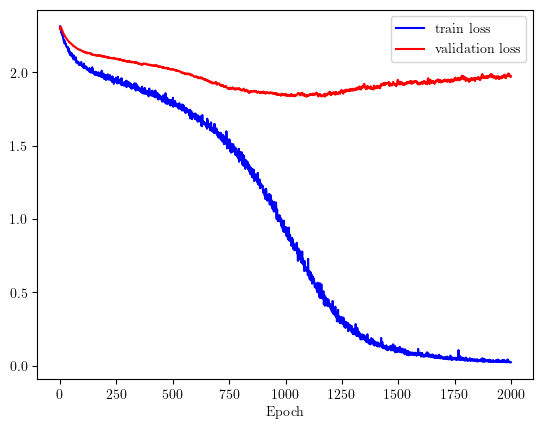

In [12]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

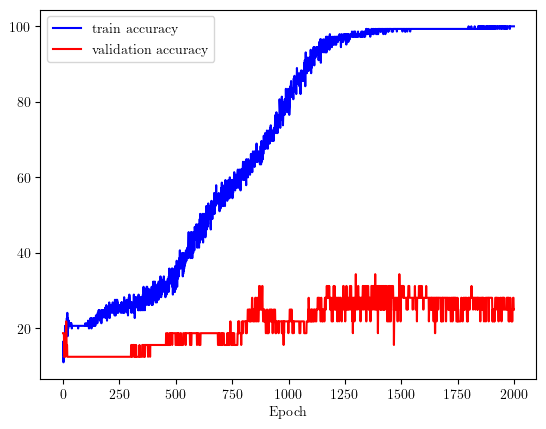

In [13]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

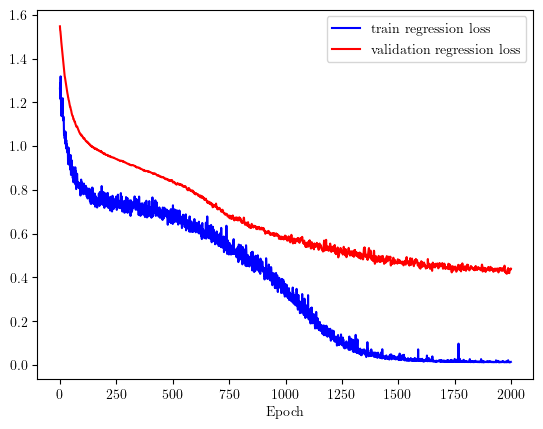

In [14]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Testing the model

In [15]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
_,\
test_accuracy,\
test_regression_loss,\
test_regression_losses,\
uncertainties = test(model,
                     device,
                     test_loader,
                     criterion_classification,
                     criterion_regression,
                     bins_midpoints,
                     uncertainty_function)

print("Test accuracy: ", test_accuracy)
print("Regression loss: ", test_regression_loss)

Test accuracy:  31.25
Regression loss:  0.3611030578613281


#### Comparing to the worst possible loss

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

dataset_dir = params.learning.DATASET+"traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)
costs = costs_df['traversal_cost'].to_numpy()
mean_dataset_value = costs_df['traversal_cost'].mean()

print(mean_dataset_value)


discretizer = KBinsDiscretizer(
            n_bins=10,
            encode="ordinal",
            strategy="quantile")
discretizer.fit(costs.reshape(-1, 1))
edges = discretizer.bin_edges_[0]
midpoints = (edges[:-1] + edges[1:])/2
print(midpoints)

mean_dataset_label = np.int32(discretizer.transform(mean_dataset_value.reshape(1, -1)))

mean_loss = 0.

# Add a progress bar
train_loader_pbar = tqdm(train_loader, unit="batch")

# Loop over the training batches
for images,\
    traversal_costs,\
    traversability_labels,\
    linear_velocities in train_loader_pbar:
    mean_tensor_label = torch.tensor(np.full(list(traversability_labels.shape), mean_dataset_label), dtype=torch.int64)
    mean_tensor_value = torch.tensor(np.full(list(traversal_costs.shape), mean_dataset_value), dtype=torch.float32)

    #loss = criterion_classification(mean_tensor_label, traversability_labels)
    #
    ## Accumulate batch loss to average over the epoch
    #train_loss += loss.item()
    #
    ## Get the number of correct predictions
    #train_correct += torch.sum(
    #    torch.argmax(mean_tensor_label, dim=1) == traversability_labels
    #    ).item()
    
    # Compute and accumulate the batch loss
    mean_loss += criterion_regression(
        mean_tensor_value,
        traversal_costs).item()

# Compute the losses and accuracies
mean_loss /= len(train_loader)
    
print(mean_loss)



1.4198158016698563
[0.14264125 0.45045804 0.76911929 1.03298158 1.23906478 1.44179508
 1.71295878 2.01825149 2.32920718 3.38650329]


100%|██████████| 5/5 [00:01<00:00,  3.63batch/s]

0.7732868015766143


#### Getting some stats about the dataset

In [17]:
from sklearn.preprocessing import KBinsDiscretizer

dataset_dir = params.learning.DATASET+"traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)

display(costs_df.groupby(['traversability_label']).count())

,image_id,traversal_cost,linear_velocity
traversability_label,,,
0,29,29,29
1,26,26,26
2,43,43,43
3,35,35,35
4,30,30,30
5,25,25,25
6,12,12,12
7,1,1,1
8,7,7,7


## Save model parameters

In [18]:
# Save the model parameters
# torch.save(model.state_dict(), "multimodal_velocity.params")

## Assessing the relevance of the uncertainty

In [19]:
import uncertainty.functions
import uncertainty.evaluation

# Compute the test losses after successive removal of the samples
# with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty =\
    uncertainty.evaluation.uncertainty_relevance(
        model,
        device,
        criterion_classification,
        criterion_regression,
        bins_midpoints,
        uncertainty_function,
        test,
        test_set,
        test_regression_loss,
        test_regression_losses,
        uncertainties)

#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

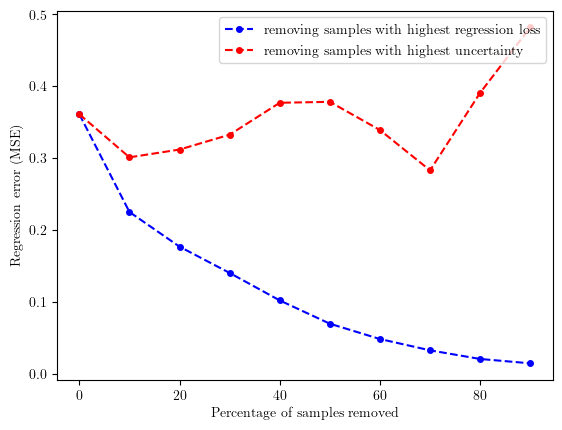

In [20]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")

## Generate a log directory

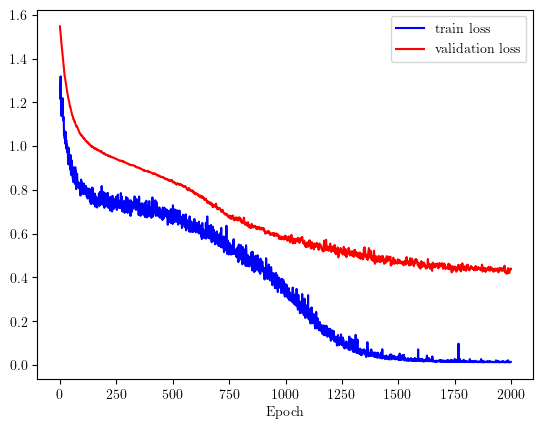

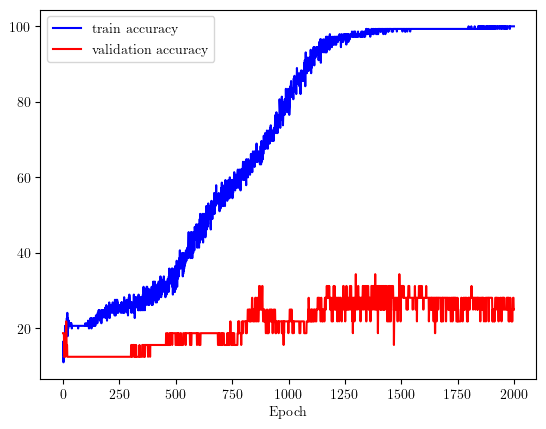

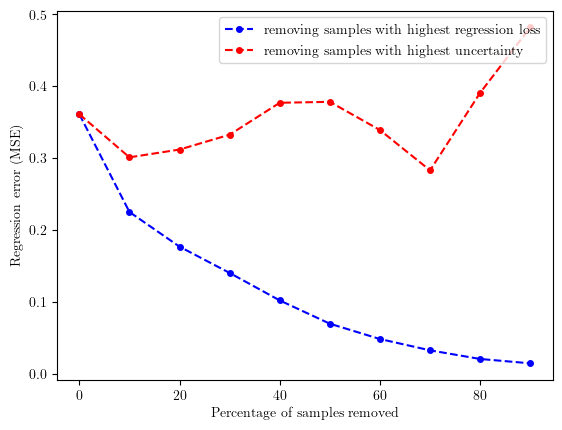

In [21]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.learning.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = "logs/_" +\
                        params.learning.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(results_directory=results_directory,
             test_regression_loss=test_regression_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             regression_loss_values=regression_loss_values,
             accuracy_values=accuracy_values,
             test_losses_loss=test_losses_loss,
             test_losses_uncertainty=test_losses_uncertainty)

### Ensemble learning

#### Training the models

In [ ]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(),
         "lr": LEARNING_PARAMS["learning_rate"] * 10},
    ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"])
    
    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = \
    uncertainty.evaluation.uncertainty_relevance_models(some_models,
                                                        device,
                                                        criterion_classification,
                                                        criterion_regression,
                                                        bins_midpoints,
                                                        uncertainty_function,
                                                        test_models,
                                                        test_set,
                                                        test_regression_loss,
                                                        test_regression_losses,
                                                        uncertainties)

#### Plotting the results

In [ ]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")